<a href="https://colab.research.google.com/github/tanyapatbks/fxproject/blob/main/Test_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
symbols = 'SIRI.BK' # Symbol on Yahoo Finance
# Available kline size "1m", "5m", "15m", "1h", "4h", "1d" for binance
kline_size = '1d'
trd_fee_pct = 0.1 # trading fee in percent
trd_fee_frac = trd_fee_pct/100
hld_fee_pct_8hr = 0 # holding fee in percent / 8hr (normal rate in Binance Future = 0.02%)
hld_fee_frac_hr = hld_fee_pct_8hr/(8*100)
OHLC_features = ['Open', 'High', 'Low', 'Close']
price_features = ['Close', 'Volume', 'Rel_Open', 'Rel_High', 'Rel_Low']
ind_features = ['Rel_SMA_fast', 'Rel_SMA_slow', 'MACD', 'ADX', 'CCI', 'ROC', 'RSI', 'TSI', '%K', '%D', '%R', 'Rel_BB_hband', 'Rel_BB_lband', 'Rel_ATR', 'UI', 'ADI', 'OBV', 'CMF', 'FI', 'MFI', 'VPT', 'VWAP']
# time_features = ['Hour_of_Day', 'Day_of_Week', 'Day_of_Month', 'Day_of_Year']
time_features = ['Day_of_Week', 'Day_of_Month', 'Day_of_Year']
trans_time_features = [f(x) for x in time_features for f in (lambda x: x + '_Sin',lambda x: x + '_Cos')]
features = price_features + trans_time_features + ind_features
targets_scale = ['Smoothed_Return*']
targets_not_scale = []
targets = targets_scale + targets_not_scale
targets2 = ['Smoothed_Price*'] # usd only for evaluation ploting
rolling_indicator = False

# Available model_no: 1 = CNN_LSTM, 2 = CNN, 3 = LSTM, 4 = LSTM_CNN, 5 = Transformer
model_no = 5
case_no = 5
cnn_no_node_list = [64, 128]
lstm_no_node_list = [64, 128]
model_name_dict = {1:'CNN-LSTM', 2:'CNN', 3:'LSTM', 4:'LSTM-CNN', 5:'Transformer'}

# time frame
time_beg_dict = {2012:'2002-01-01 00:00:00',2013:'2003-01-01 00:00:00',2014:'2004-01-01 00:00:00',2015:'2005-01-01 00:00:00', 2016:'2006-01-01 00:00:00', 2017:'2007-01-01 00:00:00', 2018:'2008-01-01 00:00:00', 2019:'2009-01-01 00:00:00', 2020:'2016-01-01 00:00:00', 2021:'2017-01-01 00:00:00', 2022:'2019-05-01 00:00:00', 2023:'2020-05-01 00:00:00' }
time_end_dict = {2012:'2013-01-01 00:00:00',2013:'2014-01-01 00:00:00',2014:'2015-01-01 00:00:00',2015:'2016-01-01 00:00:00', 2016:'2017-01-01 00:00:00', 2017:'2018-01-01 00:00:00', 2018:'2019-01-01 00:00:00', 2019:'2020-01-01 00:00:00', 2020:'2022-12-31 00:00:00', 2021:'2021-12-31 00:00:00', 2022:'2022-04-30 00:00:00', 2023:'2023-04-30 00:00:00' }
val_beg_dict = {2012:'2011-01-01 00:00:00',2013:'2012-01-01 00:00:00',2014:'2013-01-01 00:00:00',2015:'2014-01-01 00:00:00', 2016:'2015-01-01 00:00:00', 2017:'2016-01-01 00:00:00', 2018:'2017-01-01 00:00:00', 2019:'2018-01-01 00:00:00', 2020:'2019-01-01 00:00:00', 2021:'2020-01-01 00:00:00', 2022:'2020-11-01 00:00:00', 2023:'2021-11-01 00:00:00' }
test_beg_dict = {2012:'2012-01-01 00:00:00',2013:'2013-01-01 00:00:00',2014:'2014-01-01 00:00:00',2015:'2015-01-01 00:00:00', 2016:'2016-01-01 00:00:00', 2017:'2017-01-01 00:00:00', 2018:'2018-01-01 00:00:00', 2019:'2019-01-01 00:00:00', 2020:'2020-01-01 00:00:00', 2021:'2021-01-01 00:00:00', 2022:'2021-05-01 00:00:00', 2023:'2022-05-01 00:00:00' }

# define time frame to execute
test_year = 2023

# path to store experiment result
data_path = '/content/gdrive/MyDrive/MLTest/Stock/Data/'
model_path = '/content/gdrive/MyDrive/MLTest/Stock/Model/'
model_filename = model_path + symbols + '-' + kline_size + '/' + str(test_year) + '/' + str(case_no) + '/' + model_name_dict[model_no]
variable_path = model_filename + '/pre-process-variables/'
variable_filename = variable_path + 'objs.pkl'


# Train / Val / Test Split ======================================
split_type = 'time' # 'fraction', 'time'
# time_beg = '2007-01-01 00:00:00' # time begin for train-val-test
# time_end = '2018-01-01 00:00:00' # time end for train-val-test
time_beg = time_beg_dict[test_year]
time_end = time_end_dict[test_year]
# for split_type = 'fraction'
val_fraction = 0.1
test_fraction = 0.1
train_fraction = 1 - val_fraction - test_fraction
# for split_type = 'time'
val_beg = val_beg_dict[test_year]
test_beg = test_beg_dict[test_year]


T = 32 # T-days window of input data for predicting target_class
n_ind = 10 # indicator fast
k_ind = 15 # indicator slow
start_index_delta = - T - k_ind - 23 # import more bar befor time_beg for labeling
end_index_delta = 2 # import more bar after time_end for labeling

# Pre-procession features
pct_change_transform_features = ['Close', 'Volume', 'ADI', 'OBV'] # non-stationary feasture that need to transform to stationary (transform be percent change from previous time-step)
quantile_transform_features = ['Volume', 'ADI', 'OBV', 'VPT'] # Transform feature with obviuos outliner
# quantile_transform_features = ['Volume']


train_model_ = True
features_plotting = False
save_model_ = True
load_model_ = not train_model_

In [ ]:
# API (No need for Yahoo)
binance_api_key = 'jRrO0iVBepYTFfMyW4QrG1KfujEpQjQQ97MXocB3pc3Y6kSXZqMPMMS88hV5skUA'    #Enter your own API-key here
binance_api_secret = 'wK0x6YlacfWdbBUSqOKOHAHcODfEeDNNg9T5q4mk12EaohOExIuie9fVoPDY4I6v' #Enter your own API-secret here

# Function & Library

## - Install & Import

In [ ]:
_ = !pip install python-binance
_ = !pip install --upgrade gupload
_ = !pip install ta # Library for Technical Analysis
_ = !pip install pytictoc
_ = !pip install yfinance
!pip install scikit-learn==1.0.2
# _ = !pip install bta-lib # Library for Technical Analysis
# _ = !pip install tti # Library for Technical Analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 42.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# IMPORTS
import pandas as pd
import math
import os.path
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# from bitmex import bitmex
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

# save to google drive
from pydrive.auth import GoogleAuth
from google.colab import auth
from google.colab import drive

import pandas as pd
import numpy as np
import pickle
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from datetime import datetime, timedelta
import random
import warnings
from pytictoc import TicToc
t = TicToc() #create instance of class

# TA package for technical indicator
import ta as ta
from ta import add_all_ta_features
from ta.utils import dropna

# Scipy
import scipy
from scipy.signal import argrelmin, argrelmax
from scipy.signal import savgol_filter

# Keras / Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Input, Conv1D, MaxPooling1D, Flatten, GRU, Dropout, Bidirectional, Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from time import time
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras import backend as K

# Sklearn
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve, plot_precision_recall_curve


import yfinance as yf

ImportError: cannot import name 'plot_precision_recall_curve' from 'sklearn.metrics' (/usr/local/lib/python3.11/dist-packages/sklearn/metrics/__init__.py)

In [ ]:
# fix seed for all random function

seed_value = 42 # seed for all random function
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

random.seed(seed_value)

In [ ]:
# Constants
binsizes = {'1m': 1, '5m': 5, '15m': 15, '1h': 60, '4h': 240, '1d': 1440} # minutes in time step
batch_size = 750
# binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

# plot style
plt_style = 'seaborn-whitegrid'
plt.style.use(plt_style)

## - Function (Binance / Yfinance)

In [ ]:
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

In [ ]:
def get_all_binance(symbol, kline_size, save = False, path = ''):
    filename = path + '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    data_df.index = data_df.index.astype(str)
    data_df = data_df[~data_df.index.duplicated(keep='last')]
    data_df.index = pd.to_datetime(data_df.index)
    data_df = data_df[~data_df.index.duplicated(keep='last')]
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [ ]:
# load data
def get_ohlcv(name, tickers, start, end, interval, save = True):
    # if we already have a save with this name
    if os.path.exists(name):
        with open(name, "rb") as f:
            return pickle.load(f)

    ohlcv = {}
    for ticker in tickers:
        # get the data
        stock = yf.download(ticker,
                           start = start,
                           end = end,
                           interval = interval,
                           progress = False)

        # drop na rows
        stock.dropna(inplace = True)

        if len(stock) == 0: continue

        # save to dictionary by ticker
        ohlcv[ticker] = stock

    if save:
        with open(name, "wb") as f:
            pickle.dump(ohlcv, f)

    return ohlcv

## - Function (Misc.)

In [ ]:
def smooth_data_savgol_2(arr, span):
    return savgol_filter(arr, span * 2 + 1, 1)

In [ ]:
def sin_transform(values, max = np.nan, min = np.nan):
    if np.isnan(max): max = values.max()
    if np.isnan(min): min = values.min()
    return np.sin(2*np.pi*values/(max - min))

def cos_transform(values, max = np.nan, min = np.nan):
    if np.isnan(max): max = values.max()
    if np.isnan(min): min = values.min()
    return np.cos(2*np.pi*values/(max - min))

## - Backtest & Evaluation

### -- Backtest

In [ ]:
class Portfolio:
    def __init__(self, initial_capital = 1000):
        self.portfolio = {}
        self.cash = initial_capital
        self.max_port_value = initial_capital
        self.max_port_value_time = pd.Timedelta(0)

    # position
    def add_position(self, position,  # position = 'long' or 'short'
                     open_time, open_price, open_value):
        # check cash
        if self.cash < open_value:
          print('ERROR - can afford lesser amount')
          open_value = self.cash
          if open_value == 0:
            print('ERROR - cannot afford')
            return

        # check opposite position
        if position == 'long' and self.is_position('short'):
          print('ERROR - caanot open long position while there is exposure of short position')
        elif position == 'short' and self.is_position('long'):
          print('ERROR - caanot open short position while there is exposure of long position')

        self.cash -= open_value
        self.portfolio[open_time] = Trade(position, open_price, open_value)


    def close_position(self, position, close_size, close_price, close_time, trd_fee_frac, hld_fee_frac_hr):

        close_trade_list = []
        while close_size > 0:
          # Find open time to close (FIFO)
          if len(self.portfolio.items()) > 0:
            open_time = min([key for key, value in self.portfolio.items()])
          else:
            print('ERROR - No opening position to close')

          # Close whole trade
          if close_size >= self.portfolio[open_time].size:
            # find size to close
            trade_close_size = self.portfolio[open_time].size
          # Close part of trade
          else:
            # find size to close
            trade_close_size = close_size

          # to correct negative price
          close_price = max(0, close_price)

          close_trade_summary, open_value, PnL = self.portfolio[open_time].close(trade_close_size, close_price, close_time, open_time, trd_fee_frac, hld_fee_frac_hr)

          # update port
          close_size -= trade_close_size
          if position == 'long':
            self.cash += open_value + PnL # trade_close_size * close_price
          elif position == 'short':
            self.cash += open_value + PnL # trade_close_size * (self.portfolio[open_time].open_price * 2 - close_price)

          close_trade_summary.append(self.cash)
          close_trade_summary.append(self.get_total_opening_value())


          # delete trade
          if self.portfolio[open_time].size <= 0:
            del self.portfolio[open_time]

          # append trand summary
          close_trade_list.append(close_trade_summary)

        return close_trade_list

    def get_total_opening_value(self):
        return sum([value.open_price * value.size for key, value in self.portfolio.items()])


    def is_position(self, position):
        return self.get_size(position) > 0

    def update(self, close, high, low, time, trd_fee_frac, hld_fee_frac_hr):

        # update stat of all trade
        self.update_trade_stat(close, high, low, time, trd_fee_frac, hld_fee_frac_hr)

        # get port value
        port_value = self.get_total_unrealized_trade_value() + self.cash

        # to correct negative price
        port_value = max(0, port_value)

        if port_value >= self.max_port_value:
          self.max_port_value = port_value
          self.max_port_value_time = time

        dd = min((port_value - self.max_port_value) / self.max_port_value, 0)
        dd_dur = time - self.max_port_value_time

        port_size = self.get_total_size()
        return [time, port_value, port_size, dd, dd_dur]

    def get_total_unrealized_trade_value(self):
        return sum([trade.value for key, trade in self.portfolio.items()])

    def update_trade_stat(self, close, high, low, time, trd_fee_frac, hld_fee_frac_hr):
        for k, trade in self.portfolio.items():
            trade.update_stat(k, close, high, low, time, trd_fee_frac, hld_fee_frac_hr)

    def get_total_size(self):
        long_size = self.get_size('long')
        short_size = self.get_size('short')
        return long_size - short_size

    def get_size(self, position):
        return sum([value.size for key, value in self.portfolio.items() if value.position == position])

In [ ]:
class Trade:
    def __init__(self, position, open_price, open_value):

        self.position = position
        self.open_price = open_price
        self.price = open_price
        self.value = open_value
        self.size = open_value / open_price
        self.maxDD = 0


    def close(self, trade_close_size, close_price, close_time, open_time, trd_fee_frac, hld_fee_frac_hr):

        trade_close_size = trade_close_size
        open_price = self.open_price
        close_value = close_price * trade_close_size
        open_value = open_price * trade_close_size
        trd_fee = trd_fee_frac * (open_value + close_value)
        hld_dur = close_time - open_time
        hld_dur_hr = (hld_dur).total_seconds() / 3600
        hld_fee = hld_fee_frac_hr * hld_dur_hr * (open_value + close_value)/2

        if self.position == 'long':
          PnL = close_value - open_value - trd_fee - hld_fee
        elif self.position == 'short':
          PnL = open_value - close_value - trd_fee - hld_fee

        maxDD = self.maxDD
        return_frac = PnL / open_value

        win = True if return_frac > 0 else False


        # update trade
        self.size = self.size - trade_close_size
        return [self.position, open_time, close_time, open_price, close_price, trade_close_size, hld_dur, trd_fee, hld_fee, PnL, maxDD, return_frac, win], \
                open_value, PnL

    def update_stat(self, open_time, close, high, low, time, trd_fee_frac, hld_fee_frac_hr):
        self.price = close
        current_value = close * self.size
        open_value = self.open_price * self.size
        trd_fee = trd_fee_frac * open_value # trd_fee_frac * (open_value + current_value)
        hld_dur_hr = (time - open_time).total_seconds() / 3600
        hld_fee = hld_fee_frac_hr * hld_dur_hr * (open_value + current_value)/2

        if self.position == 'long':
          PnL = current_value - open_value - trd_fee - hld_fee

        elif self.position == 'short':
          PnL = open_value - current_value - trd_fee - hld_fee

        self.value = open_value + PnL # trade value
        self.maxDD = min(PnL / open_value, self.maxDD)

In [ ]:
def Backtest(df, start, end, col_name = None, initial_capital = 100,
             trd_fee_frac = 0.001, hld_fee_frac_hr = 2.5e-05 # hld_fee_frac_hr = 2.5e-05 = 0.02 %/8hr
             ):
  if col_name == None: col_name = ['Open', 'High', 'Low', 'Close', 'Long_Position', 'Short_Position', 'Long_Price', 'Short_Price']

  df = df.rename(columns={col_name[0]: 'Open',
                          col_name[1]: 'High',
                          col_name[2]: 'Low',
                          col_name[3]: 'Close',
                          col_name[4]: 'Long_Position',
                          col_name[5]: 'Short_Position',
                          col_name[6]: 'Long_Price',
                          col_name[7]: 'Short_Price'})

  # defind portfolio
  PORTFOLIO = Portfolio(initial_capital = initial_capital)
  PORTFOLIO_curve = []
  PORTFOLIO_trades = []
  PORTFOLIO_stats = {}

  for i in range(len(df)):

    # update portfolio curve
    curve = PORTFOLIO.update(close = df['Close'][i], high = df['High'][i], low = df['Low'][i],
                             time = df.index[i], trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
    PORTFOLIO_curve.append(curve)

    # check close position
    if (df['Long_Position'][i] < df['Long_Position'][i-1]):
      # close long position

      # calculate fraction for close position from current size
      close_size = ((df['Long_Position'][i-1] - df['Long_Position'][i]) / df['Long_Position'][i-1]) * PORTFOLIO.get_size('long')

      # close long position
      close_trade_list = PORTFOLIO.close_position('long', close_size = close_size, close_price = df['Long_Price'][i], close_time = df.index[i],
                                          trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)


      for j in close_trade_list:
        PORTFOLIO_trades.append(j)

    if (df['Short_Position'][i] < df['Short_Position'][i-1]):
      # close short position

      # calculate fraction for close position from current size
      close_size = ((df['Short_Position'][i-1] - df['Short_Position'][i]) / df['Short_Position'][i-1]) * PORTFOLIO.get_size('short')

      # close long position
      close_trade_list = PORTFOLIO.close_position('short', close_size = close_size, close_price = df['Short_Price'][i], close_time = df.index[i],
                                          trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)

      # record all closed trades
      for j in close_trade_list:
        PORTFOLIO_trades.append(j)

    # check open postion
    if (i == 0 and df['Long_Position'][i] > 0) or \
        (df['Long_Position'][i] > df['Long_Position'][i-1]):
      # open long position

      # calculate fraction for open position from remaining cash
      prev_long_position = df['Long_Position'][i-1] if i != 0 else 0
      open_value = (df['Long_Position'][i] - prev_long_position) * (PORTFOLIO.cash + PORTFOLIO.get_total_opening_value())

      # open long position
      PORTFOLIO.add_position('long', open_time = df.index[i], open_price = df['Long_Price'][i], open_value = open_value)

    if (i == 0 and df['Short_Position'][i] > 0) or \
        (df['Short_Position'][i] > df['Short_Position'][i-1]):
      # open short position

      # calculate fraction for open position from remaining cash
      prev_short_position = df['Short_Position'][i-1] if i != 0 else 0
      open_value = (df['Short_Position'][i] - prev_short_position) * (PORTFOLIO.cash + PORTFOLIO.get_total_opening_value())

      # open short position
      PORTFOLIO.add_position('short', open_time = df.index[i], open_price = df['Short_Price'][i], open_value = open_value)

  # portfolio stat summary
  PORTFOLIO_stats['_curve'] = pd.DataFrame(data = PORTFOLIO_curve, columns=['timestamp', 'port_value', 'port_size', 'dd', 'dd_dur'])
  PORTFOLIO_stats['_curve'] = PORTFOLIO_stats['_curve'].set_index('timestamp')

  PORTFOLIO_stats['_trades'] = pd.DataFrame(data = PORTFOLIO_trades, columns=['position', 'open_time', 'close_time', 'open_price',
                                                                              'close_price', 'trade_close_size', 'hld_dur', 'trd_fee', 'hld_fee',
                                                                              'PnL', 'maxDD', 'return_frac', 'win',
                                                                              'remain_cash', 'total_opening_value'])
  PORTFOLIO_stats['start'] = df.index[0]
  PORTFOLIO_stats['end'] = df.index[-1]
  PORTFOLIO_stats['dur'] = df.index[-1] - df.index[0]
  PORTFOLIO_stats['init_capital'] = initial_capital
  PORTFOLIO_stats['final_capital'] = PORTFOLIO_stats['_curve']['port_value'][-1]
  PORTFOLIO_stats['return_frac'] = PORTFOLIO_stats['final_capital'] / PORTFOLIO_stats['init_capital'] - 1
  PORTFOLIO_stats['return_frac_ann'] = ((1 + PORTFOLIO_stats['return_frac']) ** (365/PORTFOLIO_stats['dur'].days)) - 1

  # Asset STD
  # std_per_bar = df['Close'].pct_change().std()
  # Port STD
  std_per_bar = PORTFOLIO_stats['_curve']['port_value'].pct_change().std()
  no_bar_in_yr = 1 / ((df.index[-1] - df.index[0]).days/365/df.shape[0])

  PORTFOLIO_stats['volatility_ann'] = std_per_bar * (no_bar_in_yr ** 0.5)
  if PORTFOLIO_stats['volatility_ann'] != 0:
    PORTFOLIO_stats['sharpe_ratio_ann'] = (PORTFOLIO_stats['return_frac_ann'] - 0) / PORTFOLIO_stats['volatility_ann']
  else:
    PORTFOLIO_stats['sharpe_ratio_ann'] = np.nan
  PORTFOLIO_stats['port_mdd_frac'] = min(PORTFOLIO_stats['_curve']['dd'])
  PORTFOLIO_stats['port_mdd_dur'] = min(PORTFOLIO_stats['_curve']['dd_dur'])

  # No Trade
  if PORTFOLIO_stats['_trades'].shape[0] == 0:

    PORTFOLIO_stats['trade_mdd_frac'] = 0
    PORTFOLIO_stats['trade_P10mdd_frac'] = 0
    PORTFOLIO_stats['win_rate'] = 0
    PORTFOLIO_stats['no_trades'] = 0
    PORTFOLIO_stats['avg_hld_dur'] = pd.Timedelta(0)
    PORTFOLIO_stats['max_hld_dur'] = pd.Timedelta(0)
    PORTFOLIO_stats['reward_to_risk'] = 0
    PORTFOLIO_stats['expectency_frac'] = 0

  else:

    PORTFOLIO_stats['trade_mdd_frac'] = min(PORTFOLIO_stats['_trades']['maxDD'])
    PORTFOLIO_stats['trade_P10mdd_frac'] = np.percentile(PORTFOLIO_stats['_trades']['maxDD'], 10)
    PORTFOLIO_stats['win_rate'] = PORTFOLIO_stats['_trades']['win'].sum()/PORTFOLIO_stats['_trades']['win'].count()
    PORTFOLIO_stats['no_trades'] = PORTFOLIO_stats['_trades'].shape[0]
    PORTFOLIO_stats['avg_hld_dur'] = PORTFOLIO_stats['_trades']['hld_dur'].mean()
    PORTFOLIO_stats['max_hld_dur'] = PORTFOLIO_stats['_trades']['hld_dur'].max()

    reward = PORTFOLIO_stats['_trades']['PnL'][PORTFOLIO_stats['_trades']['PnL'] > 0].sum()
    risk = abs(PORTFOLIO_stats['_trades']['PnL'][PORTFOLIO_stats['_trades']['PnL'] < 0].sum())

    if risk != 0:
      PORTFOLIO_stats['reward_to_risk'] = reward / risk
    elif PORTFOLIO_stats['_trades']['PnL'][PORTFOLIO_stats['_trades']['PnL'] > 0].sum() > 0:
      PORTFOLIO_stats['reward_to_risk'] = np.inf
    else:
      PORTFOLIO_stats['reward_to_risk'] = 0

    PORTFOLIO_stats['expectency_frac'] = PORTFOLIO_stats['_trades']['return_frac'].mean()

  # Buy & Hold ROI/ Sharpe
  bh_std_per_bar = df['Close'].pct_change().std()
  PORTFOLIO_stats['bh_return_frac'] = (df['Close'][-1] - df['Close'][0]) / df['Close'][0]
  PORTFOLIO_stats['bh_return_frac_ann'] =  ((1 + PORTFOLIO_stats['bh_return_frac']) ** (365/PORTFOLIO_stats['dur'].days)) - 1
  PORTFOLIO_stats['bh_volatility_ann'] = bh_std_per_bar * (no_bar_in_yr ** 0.5)
  PORTFOLIO_stats['bh_sharpe_ratio_ann'] = (PORTFOLIO_stats['bh_return_frac_ann'] - 0) / PORTFOLIO_stats['bh_volatility_ann']

  return PORTFOLIO_stats

In [ ]:
def report_summary(backtest, print_report = True, return_list = False):
  start = backtest['start']
  end = backtest['end']
  dur = backtest['dur']
  init_capital = round(backtest['init_capital'],2)
  final_capital = round(backtest['final_capital'],2)
  roi = round(backtest['return_frac']*100,2)
  roi_ann = round(backtest['return_frac_ann']*100,2)
  volatility_ann = round(backtest['volatility_ann']*100,2)
  sharpe_ratio_ann = round(backtest['sharpe_ratio_ann'],2)
  port_mdd = round(backtest['port_mdd_frac']*100,2)
  trade_mdd = round(backtest['trade_mdd_frac']*100,2)
  trade_P10_mdd = round(backtest['trade_P10mdd_frac']*100,2)
  win_rate = round(backtest['win_rate']*100,2)
  no_trades = backtest['no_trades']
  avg_hld_dur = round(backtest['avg_hld_dur'].total_seconds()/3600,1)
  max_hld_dur = round(backtest['max_hld_dur'].total_seconds()/3600,1)
  reward_to_risk = round(backtest['reward_to_risk'],2)
  expectency = round(backtest['expectency_frac']*100,2)


  if print_report:
    print('Start : \t\t\t' + str(start))
    print('End : \t\t\t\t' + str(end))
    print('Duration : \t\t\t' + str(dur))
    print('Initial Capital : \t\t' + str(init_capital) + ' $')
    print('Final Capital : \t\t' + str(final_capital) + ' $')
    print('ROI : \t\t\t\t' + str(roi) + ' %')
    print('Ann. ROI : \t\t\t' + str(roi_ann) + ' %')
    print('Ann. Volatility : \t\t' + str(volatility_ann) + ' %')
    print('Ann. Sharpe Ratio : \t\t' + str(sharpe_ratio_ann))
    print('Port Max. Drawdown : \t\t' + str(port_mdd) + ' %')
    print('Trade Max. Drawdown : \t\t' + str(trade_mdd) + ' %')
    print('Trade P10 Max. Drawdown : \t' + str(trade_P10_mdd) + ' %')
    print('Win Rate : \t\t\t' + str(win_rate) + ' %')
    print('No. of trades : \t\t' + str(no_trades) + ' times')
    print('Avg. Holding Duration : \t' + str(avg_hld_dur) + ' hrs.')
    print('Max. Holding Duration : \t' + str(max_hld_dur) + ' hrs.')
    print('Rewards to Risk : \t\t' + str(reward_to_risk) + ' times')
    print('Expectency : \t\t\t' + str(expectency) + ' %')
    print('='*60)
    print('Buy&Hold ROI : \t\t\t' + str(round(backtest['bh_return_frac']*100,2)) + ' %')
    print('Buy&Hold Ann. ROI : \t\t' + str(round(backtest['bh_return_frac_ann']*100,2)) + ' %')
    print('Buy&Hold Ann. Volatility : \t' + str(round(backtest['bh_volatility_ann']*100,2)) + ' %')
    print('Buy&Hold Ann. Sharpe Ratio : \t' + str(round(backtest['bh_sharpe_ratio_ann'],2)))
    print('='*60)
    print()

  if return_list:
    return [start, end, dur, init_capital, final_capital, roi, roi_ann, volatility_ann, sharpe_ratio_ann,
            port_mdd, trade_mdd, trade_P10_mdd, win_rate, no_trades, avg_hld_dur, max_hld_dur, reward_to_risk, expectency]

### -- Model Smoothed Return

In [ ]:
# Y pred
def smoothed_return_y_pred(df, model, X, smoothed_return_scaler, date_index):
  df = df[OHLC_features + targets + targets2].copy(deep=True)
  df = df[date_index[0]:date_index[-1]].copy(deep=True)
  df['Smoothed_Return_Pred'] = model.predict(X, batch_size=BATCH, verbose=0)
  df['Smoothed_Return_Pred'] = smoothed_return_scaler.inverse_transform(df['Smoothed_Return_Pred'].values.reshape(-1,1))
  return df

In [ ]:
# create strategy
def smoothed_return_strategy(df,  thrs_l = [0, 0], # [Open (>=) , Close (<=)]
                             thrs_s = [0, 0], signal = 'Smoothed_Return_Pred'):   # [Open (<=) , Close (>=)]
  df['thrs_l_opn'] = thrs_l[0]
  df['thrs_l_cls'] = thrs_l[1]
  df['thrs_s_opn'] = thrs_s[0]
  df['thrs_s_cls'] = thrs_s[1]

  df['Long_Position'] = np.nan
  df['Long_Price'] = np.nan
  df['Short_Position'] = np.nan
  df['Short_Price'] = np.nan

  for i in range(len(df)):
    idx = df.index[i]
    # long position =======
    if i == 0:
      df.loc[idx, 'Long_Position'] = 0

    elif df[signal][i-1] < df['thrs_l_opn'][i] and df[signal][i] >= df['thrs_l_opn'][i]: # smooth return pass thrs upward
      # trigger open long position
      df.loc[idx, 'Long_Position'] = 1
      df.loc[idx, 'Long_Price'] = df['Close'][i]

    elif (df[signal][i-1] > df['thrs_l_cls'][i] and df[signal][i] <= df['thrs_l_cls'][i]) or i == len(df) - 1: # smooth return pass thrs downward
      # trigger close long position
      df.loc[idx, 'Long_Position'] = 0
      df.loc[idx, 'Long_Price'] = df['Close'][i]

    else:
      # do nothing (continue last position)
      df.loc[idx, 'Long_Position'] = df['Long_Position'][i-1]


    # short position =======
    if i == 0:
      df.loc[idx, 'Short_Position'] = 0

    elif df[signal][i-1] > df['thrs_s_opn'][i] and df[signal][i] <= df['thrs_s_opn'][i]: # smooth return pass thrs downward
      # trigger open short position
      df.loc[idx, 'Short_Position'] = 1
      df.loc[idx, 'Short_Price'] = df['Close'][i]

    elif (df[signal][i-1] < df['thrs_s_cls'][i] and df[signal][i] >= df['thrs_s_cls'][i]) or i == len(df) - 1: # smooth return pass thrs upward
      # trigger close short position
      df.loc[idx, 'Short_Position'] = 0
      df.loc[idx, 'Short_Price'] = df['Close'][i]

    else:
      # do nothing (continue last position)
      df.loc[idx, 'Short_Position'] = df['Short_Position'][i-1]

  return df

In [ ]:
def smoothed_return_report_plot(df, backtest):
  # Plot Graph

  fig,a =  plt.subplots(3, 1, figsize=(16,9), gridspec_kw={'height_ratios': [1, 2, 1]})

  # Section 1) port curve ==========================
  lns1 = a[0].plot(backtest['_curve']['port_value'], label='Port. value')
  a[0].set_ylim(backtest['_curve']['port_value'].min()*0.8,backtest['_curve']['port_value'].max()*1.1)
  a02 = a[0].twinx()
  lns2 = a02.plot(backtest['_curve']['port_size'], label='Asset Exposure', color='r', linewidth=0.5)
  # a02.set_ylim(min(0, backtest['_curve']['port_size'].min()),backtest['_curve']['port_size'].max())
  a02.grid(False)
  lns = lns1 + lns2
  labs = [l.get_label() for l in lns]
  a[0].legend(lns, labs, bbox_to_anchor=(1.15, 1))

  # Section 2) asset price curve =======================
  df['Open_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) < df['Long_Position'], df['Long_Price'], np.nan)
  df['Close_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) > df['Long_Position'], df['Long_Price'], np.nan)
  df['Open_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) < df['Short_Position'], df['Short_Price'], np.nan)
  df['Close_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) > df['Short_Position'], df['Short_Price'], np.nan)
  if df['Long_Position'][0] > 0: df['Open_Long_Price'][0] = df['Long_Price'][0]
  if df['Short_Position'][0] > 0: df['Open_Short_Price'][0] = df['Shprt_Price'][0]

  a[1].plot(df['Close'], label='Actual', linewidth=0.5)
  a[1].plot(df['Smoothed_Price*'], label='Smoothed_Price*')

  if not df['Open_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Long_Price'], c='green', label='Open_Long_Price')
  if not df['Close_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Long_Price'], c='red', label='Close_Long_Price')
  if not df['Open_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Short_Price'], c='red', label='Open_Short_Price', marker='x')
  if not df['Close_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Short_Price'], c='green', label='Close_Short_Price', marker='x')

  a[1].legend(bbox_to_anchor=(1.15, 1))
  a[1].set_ylim(df['Low'].min()*0.9,df['High'].max()*1.1)

  # Section 3) indicator curve =============================
  a[2].plot(df['Smoothed_Return*'], label='Actual')
  a[2].plot(df['Smoothed_Return_Pred'], label='Prediction')
  if not df['thrs_l_opn'].isnull().all():
    a[2].plot(df['thrs_l_opn'], label='thrs_l_opn', linewidth=0.5, c='green')
  if not df['thrs_l_cls'].isnull().all():
    a[2].plot(df['thrs_l_cls'], label='thrs_l_cls', linewidth=0.5, c='red')
  if not df['thrs_s_opn'].isnull().all():
    a[2].plot(df['thrs_s_opn'], label='thrs_s_opn', linewidth=0.5, c='red', linestyle=(0, (10,3)))
  if not df['thrs_s_cls'].isnull().all():
    a[2].plot(df['thrs_s_cls'], label='thrs_s_cls', linewidth=0.5, c='green', linestyle=(0, (10,3)))
  a[2].legend(bbox_to_anchor=(1, 1))

  plt.show()
  print()


  # scater plot btw pred and actual
  b, m = polyfit(df['Smoothed_Return*'], df['Smoothed_Return_Pred'], 1)

  x_fit_plot = [df['Smoothed_Return*'].min()*1.1, df['Smoothed_Return*'].max()*1.1]
  y_fit_plot = [b + m * i for i in x_fit_plot]
  plt.plot(x_fit_plot, y_fit_plot, '-', \
           label='pred = ' + str(round(m,5)) + '*actual + ' + str(round(b,5)) )
  plt.plot([np.min([df['Smoothed_Return*'].min(),df['Smoothed_Return_Pred'].min()])*1.1,np.max([df['Smoothed_Return*'].max(),df['Smoothed_Return_Pred'].max()])*1.1], \
           [np.min([df['Smoothed_Return*'].min(),df['Smoothed_Return_Pred'].min()])*1.1,np.max([df['Smoothed_Return*'].max(),df['Smoothed_Return_Pred'].max()])*1.1], c='r', label='x=y')
  plt.scatter(df['Smoothed_Return*'], df['Smoothed_Return_Pred'])
  plt.legend()
  plt.xlabel('actual (%)')
  plt.ylabel('prediction (%)')
  plt.show()
  print()


In [ ]:
def smoothed_return_model_results(df, model, X, date_index, target_scalers, thrs_cus = {}, initial_capital = 100):
  df_evaluation = smoothed_return_y_pred(df, model, X, target_scalers, date_index)


  min_pred = np.percentile(df_evaluation['Smoothed_Return_Pred'],10)
  max_pred = np.percentile(df_evaluation['Smoothed_Return_Pred'],90)
  # thrs_range = np.array(list(set(list(np.linspace(min_pred, max_pred, 3)) + [0])))
  thrs_range = [0]

  # Long
  df_thrs_l = []
  for thrs_l_opn in thrs_range:
    for thrs_l_cls in thrs_range:
      df_evaluation_thrs = smoothed_return_strategy(df_evaluation, thrs_l = [thrs_l_opn, thrs_l_cls], thrs_s = [np.nan, np.nan])
      backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
      df_thrs_l.append([thrs_l_opn, thrs_l_cls, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_l = pd.DataFrame(data = df_thrs_l, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])

  df_thrs_l = df_thrs_l.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Short
  df_thrs_s = []
  for thrs_s_opn in thrs_range:
    for thrs_s_cls in thrs_range:
      df_evaluation_thrs = smoothed_return_strategy(df_evaluation, thrs_l = [np.nan, np.nan], thrs_s = [thrs_s_opn, thrs_s_cls])
      backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
      df_thrs_s.append([np.nan, np.nan, thrs_s_opn, thrs_s_cls] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_s = pd.DataFrame(data = df_thrs_s, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])


  df_thrs_s = df_thrs_s.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # # Backtest report
  thrs_report = {'backtest_opt_l': {'thrs_l':[df_thrs_l['thrs_l_opn'][0], df_thrs_l['thrs_l_cls'][0]], 'thrs_s':[np.nan, np.nan]},
                 'backtest_opt_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[df_thrs_s['thrs_s_opn'][0], df_thrs_s['thrs_s_cls'][0]]},
                 'backtest_0_l': {'thrs_l':[0, 0], 'thrs_s':[np.nan, np.nan]},
                 'backtest_0_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[0, 0]}
                }

  thrs_report.update(thrs_cus)

  backtest_result = {}
  df_backtest_result = []

  for k, v in thrs_report.items():
    df_evaluation_thrs = smoothed_return_strategy(df_evaluation, thrs_l = [v['thrs_l'][0], v['thrs_l'][1]], thrs_s = [v['thrs_s'][0], v['thrs_s'][1]])
    backtest_evaluation = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
    backtest_result[k] = {'df': df_evaluation_thrs.copy(deep=True),
                          'backtest': backtest_evaluation.copy()}
    df_backtest_result.append([k] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_backtest_result = pd.DataFrame(data = df_backtest_result, columns=['name',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])


  return df_thrs_l, df_thrs_s, thrs_report, backtest_result, df_backtest_result

In [ ]:
def smoothed_return_report_summary_plot(df, backtest):
  report_summary(backtest, print_report = True, return_list = False)
  smoothed_return_report_plot(df, backtest)

# Pre-Process Data

## - Load Data

In [ ]:
def df_slice_time(df, time_beg, time_end):

  time_beg = pd.to_datetime(df.loc[time_beg:].index[0])
  time_end = pd.to_datetime(df.loc[:time_end].index[-1])

  start_index = df.index.get_loc(time_beg) + start_index_delta + 1
  end_index = df.index.get_loc(time_end) + end_index_delta

  df = df.iloc[start_index:end_index].copy(deep=True)
  return df, time_beg, time_end

In [ ]:
df = get_ohlcv('', [symbols], pd.to_datetime(time_beg) + timedelta(minutes=start_index_delta*binsizes[kline_size]*2),
               pd.to_datetime(time_end) + timedelta(minutes=end_index_delta*binsizes[kline_size]*2), kline_size, save = False)[symbols]

In [ ]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [ ]:
print(df)

            Open  High   Low  Close     Volume
Date                                          
2019-12-13  1.07  1.08  1.05   1.07   28376900
2019-12-16  1.06  1.07  1.04   1.04   18616400
2019-12-17  1.04  1.07  1.04   1.06   18624000
2019-12-18  1.06  1.09  1.06   1.07   23286600
2019-12-19  1.07  1.08  1.06   1.07   16790700
...          ...   ...   ...    ...        ...
2023-04-26  1.85  1.86  1.81   1.85  175488300
2023-04-27  1.85  1.89  1.84   1.88  142690200
2023-04-28  1.88  1.91  1.87   1.90  141593200
2023-05-02  1.90  1.91  1.86   1.89  123031300
2023-05-03  1.88  1.90  1.88   1.90   68249300

[819 rows x 5 columns]


In [ ]:
df, time_beg, time_end = df_slice_time(df, time_beg, time_end)

In [ ]:
print(df.index[0], df.index[-1])

2020-01-23 00:00:00 2023-05-02 00:00:00


In [ ]:
# df[:time_beg].shape

In [ ]:
# df[:time_beg]

## - Identifying Label

### -- Fn

In [ ]:
def df_identifying_label(df, span):
  df['Smoothed_Price*'] = smooth_data_savgol_2(np.array(df['Close']), span)
  df['Smoothed_Price*'] = smooth_data_savgol_2(np.array(df['Smoothed_Price*']), span)
  df['Smoothed_Price*'] = smooth_data_savgol_2(np.array(df['Smoothed_Price*']), span)
  df['Smoothed_Return*'] = df['Smoothed_Price*'].pct_change(1).shift(periods=-1)
  return df

In [ ]:
def plot_smoothprice(df, graph_begin, graph_end):
  plt.style.use(plt_style)

  fig,a =  plt.subplots(2, 1, figsize=(16,9), gridspec_kw={'height_ratios': [4, 1]})
  a[0].plot(df['Close'], label='Actual', linewidth=0.5)
  a[0].plot(df['Smoothed_Price*'], label='Smoothed_Price*')
  a[0].legend()
  a[0].set_xlim([graph_begin,graph_end])
  a[0].set_ylim(df['Low'][graph_begin:graph_end].min()*0.9,df['High'][graph_begin:graph_end].max()*1.1)
  a[1].plot(df['Smoothed_Return*']*100, label='Smoothed_Return*')
  a[1].set_ylabel('Return (%)')
  a[1].set_xlim([graph_begin,graph_end])
  a[1].legend()
  plt.show()

### -- Code

In [ ]:
df = df_identifying_label(df, 8)
print(df)

            Open  High   Low  Close     Volume  Smoothed_Price*  \
Date                                                              
2020-01-23  1.01  1.02  1.00   1.01   20592500         1.008936   
2020-01-24  1.01  1.02  1.01   1.01    3064200         1.007107   
2020-01-27  1.01  1.02  0.98   0.98   30322800         1.005277   
2020-01-28  0.98  1.01  0.98   0.99   13570200         1.003448   
2020-01-29  0.99  1.01  0.99   1.00   10466200         1.001618   
...          ...   ...   ...    ...        ...              ...   
2023-04-25  1.85  1.88  1.82   1.86  189499100         1.856093   
2023-04-26  1.85  1.86  1.81   1.85  175488300         1.864973   
2023-04-27  1.85  1.89  1.84   1.88  142690200         1.873853   
2023-04-28  1.88  1.91  1.87   1.90  141593200         1.882733   
2023-05-02  1.90  1.91  1.86   1.89  123031300         1.891613   

            Smoothed_Return*  
Date                          
2020-01-23         -0.001813  
2020-01-24         -0.001817  
2020

In [ ]:
if features_plotting:
  graph_begin = df.index[-600]
  graph_end = df.index[-1]
  # graph_begin = pd.to_datetime(time_beg)
  # graph_end = pd.to_datetime(time_end)
  # graph_begin = pd.to_datetime('2018-09-01')
  # graph_end =pd.to_datetime('2018-11-30')
  plot_smoothprice(df, graph_begin, graph_end)

## - Extract Feature

### -- Function

In [ ]:
def df_extract_feature(df, rolling_indicator = False):
  df['Rel_Open'] = (df['Open'] - df['Close'])/df['Close']
  df['Rel_High'] = (df['High'] - df['Close'])/df['Close']
  df['Rel_Low'] = (df['Low'] - df['Close'])/df['Close']

  df['Hour_of_Day'] = ((df.index.hour * 60) + (df.index.minute)) / (60*24) # unit = day, min = 0, max = 1
  df['Day_of_Week'] = (df.index.dayofweek + df['Hour_of_Day']) / 7 # unit = week, min = 0, max = 1
  df['Day_of_Month'] = ((df.index.day - 1) + df['Hour_of_Day']) / df.index.daysinmonth # unit = month, min = 0, max = 1
  df['Day_of_Year'] = ((df.index.dayofyear - 1) + df['Hour_of_Day']) / (df.index.is_leap_year*366 + np.logical_not(df.index.is_leap_year)*365) # unit = year, min = 0, max = 1


  for i in time_features:
    df[i + '_Sin'] = sin_transform(df[i], max=1, min=0)
    df[i + '_Cos'] = cos_transform(df[i], max=1, min=0)

  # Create Indicator Column

  # SMA
  df['Rel_SMA_fast'] = (ta.trend.SMAIndicator(close=df['Close'], window=n_ind, fillna=False).sma_indicator() - df['Close']) / df['Close']
  df['Rel_SMA_slow'] = (ta.trend.SMAIndicator(close=df['Close'], window=k_ind, fillna=False).sma_indicator() - df['Close']) / df['Close']

  # CCI
  df['CCI'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=n_ind, constant=0.015, fillna=False).cci()

  # ROC
  df['ROC'] = ta.momentum.ROCIndicator(close=df['Close'], window=n_ind, fillna=False).roc()

  # %R
  df['%R'] = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=n_ind, fillna=False).williams_r()

  # MFI
  df['MFI'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=n_ind, fillna=False).money_flow_index()

  # VPT
  df['VPT'] = ta.volume.VolumePriceTrendIndicator(close=df['Close'], volume=df['Volume'], fillna=False).volume_price_trend()
  df.loc[df.index[0], 'VPT'] = np.nan
  df.loc[df.index[1], 'VPT'] = np.nan = np.nan # correct library bug. the first 2 row in VPT should be np.nan

  # VWAP
  df['VWAP'] = (ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=n_ind, fillna=False).volume_weighted_average_price()- df['Close']) / df['Close']

  # indicator that needs to use rolling windows
  # ['MACD', 'ADX', 'RSI', 'TSI', '%K', '%D', 'Rel_BB_hband', 'Rel_BB_lband', 'Rel_ATR', 'UI', 'ADI', 'OBV', 'CMF', 'FI']

  rolling_windows = abs(start_index_delta + T)
  if rolling_indicator:
    # Rolling calculate some indicators
    for i in range(len(df)):
      if i < rolling_windows - 1:
        df.loc[df.index[i], 'MACD'] = np.nan
        df.loc[df.index[i], 'ADX'] = np.nan
        df.loc[df.index[i], 'RSI'] = np.nan
        df.loc[df.index[i], 'TSI'] = np.nan
        df.loc[df.index[i], '%K'] = np.nan
        df.loc[df.index[i], '%D'] = np.nan
        df.loc[df.index[i], 'Rel_BB_hband'] = np.nan
        df.loc[df.index[i], 'Rel_BB_lband'] = np.nan
        df.loc[df.index[i], 'Rel_ATR'] = np.nan
        df.loc[df.index[i], 'UI'] = np.nan
        df.loc[df.index[i], 'ADI'] = np.nan
        df.loc[df.index[i], 'OBV'] = np.nan
        df.loc[df.index[i], 'CMF'] = np.nan
        df.loc[df.index[i], 'FI'] = np.nan
      else:
        df.loc[df.index[i], 'MACD'] = ta.trend.macd(close=df['Close'][i-rolling_windows+1:i+1], window_slow=k_ind, window_fast=n_ind, fillna=False)[-1]
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        df.loc[df.index[i], 'ADX'] = ta.trend.ADXIndicator(high=df['High'][i-rolling_windows+1:i+1], low=df['Low'][i-rolling_windows+1:i+1], close=df['Close'][i-rolling_windows+1:i+1], window=n_ind, fillna=False).adx()[-1]
        df.loc[df.index[i], 'RSI'] = ta.momentum.RSIIndicator(close=df['Close'][i-rolling_windows+1:i+1], window=n_ind, fillna=False).rsi()[-1]
        df.loc[df.index[i], 'TSI'] = ta.momentum.TSIIndicator(close=df['Close'][i-rolling_windows+1:i+1], window_slow=k_ind, window_fast=n_ind, fillna=False).tsi()[-1]
        df.loc[df.index[i], '%K'] = ta.momentum.StochRSIIndicator(close=df['Close'][i-rolling_windows+1:i+1], window=n_ind, smooth1=n_ind, smooth2=n_ind, fillna=False).stochrsi_k()[-1]
        df.loc[df.index[i], '%D'] = ta.momentum.StochRSIIndicator(close=df['Close'][i-rolling_windows+1:i+1], window=n_ind, smooth1=n_ind, smooth2=n_ind, fillna=False).stochrsi_d()[-1]
        df.loc[df.index[i], 'Rel_BB_hband'] = (ta.volatility.BollingerBands(close=df['Close'][i-rolling_windows+1:i+1], window=n_ind, window_dev=2, fillna=False).bollinger_hband()[-1] - df['Close'][i]) / df['Close'][i]
        df.loc[df.index[i], 'Rel_BB_lband'] = (ta.volatility.BollingerBands(close=df['Close'][i-rolling_windows+1:i+1], window=n_ind, window_dev=2, fillna=False).bollinger_lband()[-1] - df['Close'][i]) / df['Close'][i]
        df.loc[df.index[i], 'Rel_ATR'] = ta.volatility.AverageTrueRange(high=df['High'][i-rolling_windows+1:i+1], low=df['Low'][i-rolling_windows+1:i+1], close=df['Close'][i-rolling_windows+1:i+1], window=n_ind, fillna=False).average_true_range()[-1] / df['Close'][i]
        df.loc[df.index[i], 'UI'] = ta.volatility.UlcerIndex(close=df['Close'][i-rolling_windows+1:i+1], window=n_ind, fillna=False).ulcer_index()[-1]
        df.loc[df.index[i], 'ADI'] = ta.volume.AccDistIndexIndicator(high=df['High'][i-rolling_windows+1:i+1], low=df['Low'][i-rolling_windows+1:i+1], close=df['Close'][i-rolling_windows+1:i+1], volume=df['Volume'][i-rolling_windows+1:i+1], fillna=False).acc_dist_index()[-1]
        df.loc[df.index[i], 'OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'][i-rolling_windows+1:i+1], volume=df['Volume'][i-rolling_windows+1:i+1], fillna=False).on_balance_volume()[-1]
        df.loc[df.index[i], 'CMF'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'][i-rolling_windows+1:i+1], low=df['Low'][i-rolling_windows+1:i+1], close=df['Close'][i-rolling_windows+1:i+1], volume=df['Volume'][i-rolling_windows+1:i+1], window=n_ind, fillna=False).chaikin_money_flow()[-1]
        df.loc[df.index[i], 'FI'] = ta.volume.ForceIndexIndicator(close=df['Close'][i-rolling_windows+1:i+1], volume=df['Volume'][i-rolling_windows+1:i+1], window=n_ind, fillna=False).force_index()[-1]
      warnings.filterwarnings('default', category=RuntimeWarning)
  else:
    # MACD
    df['MACD'] = ta.trend.macd(close=df['Close'], window_slow=k_ind, window_fast=n_ind, fillna=False)

    # ADX # create warning but the results are correct
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=n_ind, fillna=False).adx()
    warnings.filterwarnings('default', category=RuntimeWarning)

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=n_ind, fillna=False).rsi()

    # TSI
    df['TSI'] = ta.momentum.TSIIndicator(close=df['Close'], window_slow=k_ind, window_fast=n_ind, fillna=False).tsi()

    # %K
    df['%K'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=n_ind, smooth1=n_ind, smooth2=n_ind, fillna=False).stochrsi_k()

    # %D
    df['%D'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=n_ind, smooth1=n_ind, smooth2=n_ind, fillna=False).stochrsi_d()

    # Bollinger Bands
    df['Rel_BB_hband'] = (ta.volatility.BollingerBands(close=df['Close'], window=n_ind, window_dev=2, fillna=False).bollinger_hband() - df['Close']) / df['Close']
    df['Rel_BB_lband'] = (ta.volatility.BollingerBands(close=df['Close'], window=n_ind, window_dev=2, fillna=False).bollinger_lband() - df['Close']) / df['Close']

    # ATR
    df['Rel_ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=n_ind, fillna=False).average_true_range() / df['Close']

    # UI
    df['UI'] = ta.volatility.UlcerIndex(close=df['Close'], window=n_ind, fillna=False).ulcer_index()

    # ADI (Accumulation/Distribution Index)
    df['ADI'] = ta.volume.AccDistIndexIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], fillna=False).acc_dist_index()

    # OBV
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'], fillna=False).on_balance_volume()

    # CMF
    df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=n_ind, fillna=False).chaikin_money_flow()

    # FI
    df['FI'] = ta.volume.ForceIndexIndicator(close=df['Close'], volume=df['Volume'], window=n_ind, fillna=False).force_index()

    # add np.nan to let prepended row equal to rolling windows case
    df.loc[df.head(rolling_windows).index,'%D'] = np.nan

  return df


In [ ]:
# Cleaning df
def df_cleaning(df, target_col = True):

  if target_col == True:
    target_col = targets + targets2
  else:
    target_col = []

  # # Clean row
  # df.dropna(axis=0, how='any', subset=ind_features + target_col, inplace=True)

  # Clean Column
  df = df[target_col + list(dict.fromkeys(OHLC_features + features))].copy(deep=True)

  return df

In [ ]:
def plot_original(df):
  # Plot the original time series
  print('Visualization of the original Time Series\n')

  plt.style.use(plt_style)
  df.plot(subplots=True,
          layout=(math.ceil(len(df.columns)/3), 3),
          figsize=(24,40),
          fontsize=10,
          linewidth=1.5,
          sharex=False)
  plt.show()
  print()

In [ ]:
def plot_original_corr(df):
  # Let's also draw a heatmap visualization of the correlation matrix
  corr_matrix = df.corr(method='spearman')
  f, ax = plt.subplots(figsize=(16,8))
  sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
              annot_kws={"size": 7}, cmap='coolwarm', ax=ax)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.show()
  print()

### -- Code

In [ ]:
t.tic()
df = df_extract_feature(df, rolling_indicator)
t.toc()

Elapsed time is 0.191889 seconds.


In [ ]:
df = df_cleaning(df)

In [ ]:
if features_plotting:
  plot_original(df)
  plot_original_corr(df)

## - Feature Engineering

### -- Function

In [ ]:
def df_transform_pct_change(df, pct_change_transform_features):
  # transform feature to percent change from previous time step
  df_transform = df[list(set(df.columns).intersection(pct_change_transform_features))].copy(deep=True).pct_change(1)
  # df_transform.fillna(method='bfill', inplace=True)

  df_transform[list(set(features) - set(pct_change_transform_features))] = df[list(set(features) - set(pct_change_transform_features))].copy(deep=True)

  df_transform = df_transform[features]

  for i in list(set(df.columns).intersection(pct_change_transform_features)):
    df_transform[i].replace(np.inf, df_transform.loc[df_transform[i] != np.inf, i].max(), inplace=True)
    df_transform[i].replace(-np.inf, df_transform.loc[df_transform[i] != -np.inf, i].min(), inplace=True)

  # Clean row
  df.dropna(axis=0, how='any', subset=list(set(df.columns).intersection(targets+ind_features)), inplace=True)
  df_transform.dropna(axis=0, how='any', subset=list(set(df_transform.columns).intersection(targets+ind_features)), inplace=True)
  idx = df.index.intersection(df_transform.index)
  df = df.loc[idx]
  df_transform = df_transform.loc[idx]

  return df.copy(deep=True), df_transform.copy(deep=True)


In [ ]:
def plot_pct_change(df_transform):
  # Plot the transformed time series
  print('Visualization of the transformed Features\n')
  print(str(pct_change_transform_features) + ' was transformed to percent change from previous time step.\n')

  plt.style.use(plt_style)
  df_transform.plot(subplots=True,
          layout=(math.ceil(len(df_transform.columns)/3), 3),
          figsize=(24,40),
          fontsize=10,
          linewidth=1.5,
          sharex=False)
  plt.show()
  print()
  # Plot the original time series
  print('Distribution of the transformed Features\n')
  print(str(pct_change_transform_features) + ' was transformed to percent change from previous time step.\n')

  plt.style.use(plt_style)
  df_transform.hist(bins=50,
                    figsize=(24, 10),
                    layout=(math.ceil(len(df_transform.columns)/8), 8))
  plt.show()
  print()

### -- Code

In [ ]:
df, df_transform = df_transform_pct_change(df, pct_change_transform_features)

In [ ]:
# check proper start_index_delta with these 2 df
# these 2 df should not contain any N/A
# these 2 df should have row = T
# df_transform[:time_beg].shape
# df[:time_beg].shape

In [ ]:
if features_plotting: plot_pct_change(df_transform)

## - Train / Val / Test Split

### -- Function

In [ ]:
def correct_val_test_beg(df, val_beg, test_beg):
  val_beg = pd.to_datetime(df_transform.loc[val_beg:].index[0])
  test_beg = pd.to_datetime(df_transform.loc[test_beg:].index[0])
  return val_beg, test_beg

In [ ]:
def df_train_test_split(df_transform, split_type = split_type,  # split_type = 'fraction' or 'time
                        split_boundary = (train_fraction, val_beg), T = T):   # train_fraction = 0.6 for fraction and val_beg = '2004-11-12 00:00:00' for time. only use one of them.
  if split_type == 'fraction':
    # Split train and test data
    train_features = df_transform.loc[:df_transform.index[int(df_transform.shape[0]*split_boundary[0])]].copy(deep=True)
    train_labels = df.loc[:df_transform.index[int(df_transform.shape[0]*split_boundary[0])], targets].copy(deep=True)

    test_features = df_transform.loc[df_transform.index[int(df_transform.shape[0]*split_boundary[0]) + 1]:].copy(deep=True)
    test_labels = df.loc[df_transform.index[int(df_transform.shape[0]*split_boundary[0]) + 1]:, targets].copy(deep=True)

  elif split_type == 'time':
    train_features = df_transform[:df.index.get_loc(split_boundary[1])].copy(deep=True)
    train_labels = df[:df.index.get_loc(split_boundary[1])][targets].copy(deep=True)

    test_features = df_transform[df.index.get_loc(split_boundary[1]):].copy(deep=True)
    test_labels = df[df.index.get_loc(split_boundary[1]):][targets].copy(deep=True)

  prepend_features = train_features.iloc[-(T-1):]
  test_features = pd.concat([prepend_features, test_features], axis=0)

  # train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

  return train_features, train_labels, test_features, test_labels

In [ ]:
def df_transform_quantile(train_features, test_features, quantile_transform_features):
  quantile_transform_features = list(set(train_features.columns).intersection(quantile_transform_features))

  quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=min(train_features.shape[0],1000))

  train_features = train_features.copy(deep=True)
  test_features = test_features.copy(deep=True)

  train_features[quantile_transform_features] = pd.DataFrame(quantile_transformer.fit_transform(train_features[quantile_transform_features].values),
                                      index=train_features[quantile_transform_features].index,
                                      columns=train_features[quantile_transform_features].columns)

  test_features[quantile_transform_features] = pd.DataFrame(quantile_transformer.transform(test_features[quantile_transform_features].values),
                                      index=test_features[quantile_transform_features].index,
                                      columns=test_features[quantile_transform_features].columns).copy(deep=True)


  return train_features, test_features, quantile_transformer

In [ ]:
def plot_quantile_transformed(train_features):
  print('Visualization of the quantile transformed Features\n')
  print(str(quantile_transform_features) + ' is quantile transformed\n')

  plt.style.use(plt_style)
  train_features.plot(subplots=True,
          layout=(math.ceil(len(train_features.columns)/3), 3),
          figsize=(24,40),
          fontsize=10,
          linewidth=1.5,
          sharex=False)
  plt.show()

  print()
  print('Distribution of the quantile transformed Features\n')
  print(str(quantile_transform_features) + ' is quantile transformed\n')

  plt.style.use(plt_style)
  train_features.hist(bins=50,
                    figsize=(24, 10),
                    layout=(math.ceil(len(train_features.columns)/8), 8))
  plt.show()

In [ ]:
def df_feature_scaling(train_features, test_features):
  # Rescale the features by minmax scaler [0,1]

  # scaler = StandardScaler()  # MinMaxScaler(feature_range=(0,1))
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_train_features = pd.DataFrame(scaler.fit_transform(train_features.values),
                                      index=train_features.index,
                                      columns=train_features.columns)

  # The Scaler is fit on the training set and then applied to the test set
  scaled_test_features = pd.DataFrame(scaler.transform(test_features.values),
                                      index=test_features.index,
                                      columns=test_features.columns)

  # scaled_train_features.shape, scaled_test_features.shape
  return scaled_train_features, scaled_test_features, scaler

In [ ]:
def df_label_scaling(train_labels, test_labels):
  # Rescale the target (High return and Low return) by minmax scaler [0,1]
  target_scalers = {}
  scaled_train_labels = train_labels.copy(deep=True)
  scaled_test_labels = test_labels.copy(deep=True)

  for i in targets_scale:
    target_scalers[i] = MinMaxScaler(feature_range=(0,1))
    s_temp = target_scalers[i].fit_transform(train_labels[i].values.reshape(-1,1))
    s_temp = np.reshape(s_temp,len(s_temp))
    scaled_train_labels[i] = s_temp

    s_temp = target_scalers[i].transform(test_labels[i].values.reshape(-1,1))
    s_temp = np.reshape(s_temp,len(s_temp))
    scaled_test_labels[i] = s_temp

  return scaled_train_labels, scaled_test_labels, target_scalers

In [ ]:
def plot_scaling(scaled_train_labels, scaled_train_features):
  # Plot the rescaled_train_features
  print('Visualization of the scaled Train Features\n')
  plt.style.use(plt_style)
  pd.concat([scaled_train_labels, scaled_train_features], axis=1).plot(subplots=True,
          layout=(math.ceil((len(scaled_train_labels.columns)+len(scaled_train_features.columns))/3), 3),
          figsize=(24,40),
          fontsize=10,
          linewidth=1.5,
          sharex=False)
  plt.show()

### -- Code

In [ ]:
val_beg, test_beg = correct_val_test_beg(df, val_beg, test_beg)

In [ ]:
train_features, train_labels, test_features, test_labels = df_train_test_split(df_transform, split_type, (train_fraction, val_beg), T)
quantile_transform_features = list(set(train_features.columns).intersection(quantile_transform_features))
train_features, test_features, quantile_transformer = df_transform_quantile(train_features, test_features, quantile_transform_features)

In [ ]:
if features_plotting: plot_quantile_transformed(train_features)

In [ ]:
scaled_train_features, scaled_test_features, scaler = df_feature_scaling(train_features, test_features)
scaled_train_labels, scaled_test_labels, target_scalers = df_label_scaling(train_labels, test_labels)

In [ ]:
if features_plotting: plot_scaling(scaled_train_labels, scaled_train_features)

In [ ]:
print('scaled_train_features')
print('prepend beginning : ' + str(scaled_test_features.index[0]))
print('beginning : ' + str(scaled_train_features.index[T-1]))
print('ending : ' + str(scaled_train_features.index[-1]))
print('='*100)
print('scaled_test_features')
print('prepend beginning : ' + str(scaled_test_features.index[0]))
print('beginning : ' + str(scaled_test_features.index[T-1]))
print('ending : ' + str(scaled_test_features.index[-1]))

scaled_train_features
prepend beginning : 2021-09-14 00:00:00
beginning : 2020-05-05 00:00:00
ending : 2021-10-29 00:00:00
scaled_test_features
prepend beginning : 2021-09-14 00:00:00
beginning : 2021-11-01 00:00:00
ending : 2023-04-28 00:00:00


## - Data Pre-Processing for NN model

### -- Function

In [ ]:
def df_Xy4NN(scaled_train_features, scaled_train_labels, scaled_test_features, scaled_test_labels):
  # Create sequences of T timesteps
  X_train, y_train = [], []
  train_date = []
  for i in range(scaled_train_labels.shape[0] - (T-1)):
      train_date.append(scaled_train_labels.index[i + (T-1)])
      X_train.append(scaled_train_features.iloc[i:i+T].values)
      y_train.append(scaled_train_labels.iloc[i + (T-1)])
  X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,len(targets))

  X_test, y_test = [], []
  test_date = []
  for i in range(scaled_test_labels.shape[0]):
      test_date.append(scaled_test_labels.index[i])
      X_test.append(scaled_test_features.iloc[i:i+T].values)
      y_test.append(scaled_test_labels.iloc[i])
  X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,len(targets))

  return X_train, y_train, train_date, \
        X_test, y_test, test_date

In [ ]:
def df_val_test_split(test_features, test_labels,
                      scaled_test_features, scaled_test_labels,
                      X_test, y_test, test_date,
                      split_type = 'fraction',  # split_type = 'fraction' or 'time
                      split_boundary = (train_fraction, test_beg), T = T, report_shape = False):  # train_fraction = 0.6 for fraction and val_beg = '2004-11-12 00:00:00' for time. only use one of them.

  if split_type == 'fraction':
    num_val = int((val_fraction/(val_fraction+test_fraction))*X_test.shape[0])
  elif split_type == 'time':
    num_val = scaled_test_labels.index.get_loc(split_boundary[1])

  X_val, y_val = X_test[:num_val], y_test[:num_val]
  val_features = test_features[:num_val + T-1]
  scaled_val_features = scaled_test_features[:num_val + T-1]
  val_labels = test_labels[:num_val]
  val_date = test_date[:num_val]

  X_test, y_test = X_test[num_val:], y_test[num_val:]
  test_features = test_features[num_val:]
  scaled_test_features = scaled_test_features[num_val:]
  test_labels = test_labels[num_val:]
  test_date = test_date[num_val:]

  if report_shape:
    print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')
    print(f'Validation data dimensions: {X_val.shape}, {y_val.shape}')
    print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')
    print('='*100)
    print(f'Train period : ' + str(train_date[0]) + ' to ' + str(train_date[-1]))
    print(f'Validation period : ' + str(val_date[0]) + ' to ' + str(val_date[-1]))
    print(f'Test period : ' + str(test_date[0]) + ' to ' + str(test_date[-1]))

  return X_val, y_val, val_features, scaled_val_features, val_labels, val_date, \
  X_test, y_test, test_features, scaled_test_features, test_labels, test_date

### -- Code

In [ ]:
X_train, y_train, train_date, \
X_test, y_test, test_date \
= df_Xy4NN(scaled_train_features, scaled_train_labels, scaled_test_features, scaled_test_labels)

In [ ]:
X_val, y_val, val_features, scaled_val_features, val_labels, val_date, \
  X_test, y_test, test_features, scaled_test_features, test_labels, test_date \
= df_val_test_split(test_features, test_labels,
                      scaled_test_features, scaled_test_labels,
                      X_test, y_test, test_date,
                      split_type = split_type,  # split_type = 'fraction' or 'time
                      split_boundary = (train_fraction, test_beg), T = T, report_shape = True)

Train data dimensions: (358, 32, 33), (358, 1)
Validation data dimensions: (121, 32, 33), (121, 1)
Test data dimensions: (242, 32, 33), (242, 1)
Train period : 2020-05-05 00:00:00 to 2021-10-29 00:00:00
Validation period : 2021-11-01 00:00:00 to 2022-04-29 00:00:00
Test period : 2022-05-03 00:00:00 to 2023-04-28 00:00:00


In [ ]:
y_train = list(np.swapaxes(y_train,0,1))
y_val = list(np.swapaxes(y_val,0,1))
y_test = list(np.swapaxes(y_test,0,1))

# Model

In [ ]:
losses = {'class' : 'MeanSquaredError'}
matrics = {'class' : 'MeanSquaredError'}

## Model 1 (CNN-LSTM)

In [ ]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Conv1D, Input, BatchNormalization
from keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_data(X_train, X_test):
    scaler = MinMaxScaler()
    for i in range(X_train.shape[-1]):  # Loop over each feature
        X_train[:, :, i] = scaler.fit_transform(X_train[:, :, i])
        X_test[:, :, i] = scaler.transform(X_test[:, :, i])
    return X_train, X_test

X_train, X_test = normalize_data(X_train, X_test)  # Add your own X_train and X_test here

def get_CNN_LSTM(LR, cnn_no_node, lstm_no_node):
    input1 = Input(shape=(T, N))

    x = Conv1D(filters=cnn_no_node * 2, kernel_size=15, strides=1, padding='same',
               activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005))(input1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(filters=cnn_no_node, kernel_size=15, strides=1, padding='same',
               activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = LSTM(lstm_no_node * 2, dropout=0.2, recurrent_dropout=0.2, activation='relu',
             return_sequences=False, kernel_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
    x = BatchNormalization()(x)

    x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = Dropout(0.4)(x)

    out = Dense(1, activation='relu', name='class')(x)  # Changed to relu activation for non-negative outputs

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(learning_rate=LR),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

## Model 2 (CNN)

In [ ]:
def get_CNN(LR, cnn_no_node, lstm_no_node):
  input1 = Input(shape=(T,N))
  x = Conv1D(filters=cnn_no_node, kernel_size=15, strides=1, padding='same', activation='relu')(input1)
  x = AveragePooling1D(pool_size=2, strides=1, padding='same')(x)
  x = Flatten()(x)
  x = BatchNormalization()(x)
  x = Dense(64)(x)
  x = Dropout(0.4)(x)
  out = Dense(1, activation='sigmoid', name='class')(x)

  model = Model(inputs=input1, outputs=out)
  model.compile(optimizer=Adam(learning_rate=LR),
                loss=losses,
                metrics=matrics)
  return model

## Model 3 (LSTM)

In [ ]:
def get_LSTM(LR, cnn_no_node, lstm_no_node):
  input1 = Input(shape=(T,N))
  x = LSTM(lstm_no_node, dropout=0.2, recurrent_dropout=0.2, activation='relu', return_sequences=False)(input1)
  x = BatchNormalization()(x)
  x = Dense(64)(x)
  x = Dropout(0.4)(x)
  out = Dense(1, activation='sigmoid', name='class')(x)

  model = Model(inputs=input1, outputs=out)
  model.compile(optimizer=Adam(learning_rate=LR),
                loss=losses,
                metrics=matrics)
  return model

## Model 4 LSTM-CNN

In [ ]:
from tensorflow.keras.layers import LeakyReLU, Activation

def get_LSTM_CNN(LR, cnn_no_node, lstm_no_node):
    input1 = Input(shape=(T,N))
    activation = LeakyReLU(alpha=0.1)

    x = LSTM(lstm_no_node, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(input1)
    x = Activation(activation)(x)
    x = LSTM(lstm_no_node, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(x)
    x = Activation(activation)(x)

    x = Conv1D(filters=cnn_no_node, kernel_size=15, strides=1, padding='same', activation='relu')(x)
    x = Conv1D(filters=cnn_no_node * 2, kernel_size=7, strides=1, padding='same', activation='relu')(x)

    x = GlobalAveragePooling1D()(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    out = Dense(1, activation='linear', name='output')(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(learning_rate=LR),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

## Model 5 (Transformer) - with CNN-LSTM layer

In [ ]:
from tensorflow.keras.layers import *

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2

def get_Transformer(LR, cnn_no_node, lstm_no_node):
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(T)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(T, N))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))

  # Implement a CNN layer
  x = Conv1D(cnn_no_node, 5, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  # Implement a LSTM layer
  x = LSTM(lstm_no_node, return_sequences=True)(x)
  x = Flatten()(x)

  x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
  x = Dropout(0.2)(x)
  out = Dense(1, activation='linear', name='class')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=LR), metrics=['mae'])
  return model

In [ ]:
# batch_size = 32
# seq_len = T

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [ ]:
# model = get_Transformer()
# model.summary()

In [ ]:
# callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5',
#                                               monitor='val_loss',
#                                               save_best_only=True, verbose=1)

# history = model.fit(X_train, y_train[0],
#                     batch_size=batch_size,
#                     epochs=35,
#                     callbacks=[callback],
#                     validation_data=(X_val, y_val[0]))

# model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
#                                    custom_objects={'Time2Vector': Time2Vector,
#                                                    'SingleAttention': SingleAttention,
#                                                    'MultiAttention': MultiAttention,
#                                                    'TransformerEncoder': TransformerEncoder})

## - Train

### -- Function

In [ ]:
def save_variable(History):
  if 'scaler' in globals() and 'quantile_transformer' in globals() and 'target_scalers' in globals():
    if not os.path.isdir(variable_path):
        os.mkdir(variable_path)

    with open(variable_filename, 'wb') as f:
        pickle.dump([scaler, quantile_transformer, target_scalers, History], f)

def load_variable():
  with open(variable_filename, 'rb') as f:  # Python 3: open(..., 'rb')
    scaler, quantile_transformer, target_scalers, History = pickle.load(f)

  return scaler, quantile_transformer, target_scalers, History

In [ ]:
def train_model_grid_search(model_no, cnn_no_node_list, lstm_no_node_list):
  global LR, EPOCH

  if model_no == 1:
    get_model = get_CNN_LSTM

  elif model_no == 2:
    get_model = get_CNN
    lstm_no_node_list = [0]

  elif model_no == 3:
    get_model = get_LSTM
    cnn_no_node_list = [0]

  elif model_no == 4:
    get_model = get_LSTM_CNN

  elif model_no == 5:
    get_model = get_Transformer
    # LR = 1e-4
    # EPOCH = 50

  # Define a learning rate decay method:
  lr_decay = ReduceLROnPlateau(monitor='val_loss',
                              patience=5, verbose=1,
                              factor=0.8, min_lr=1e-6, cooldown=0)
  # Define Early Stopping:
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0,
                           patience=60, verbose=1, mode='auto',
                           baseline=None, restore_best_weights=True)

  best_val_loss = float('inf')

  grid_no = 1
  df_grid_results = []

  # history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.0,  validation_data=(X_val, y_val), batch_size=32)

  if load_model_:
    model = load_model(model_filename)
    if train_model_:
      print('model.optimizer.lr: ',model.optimizer.lr)
      print('LR: ',LR)
      K.set_value(model.optimizer.lr, LR) # reset learning rate
      History = model.fit(X_train, y_train,
                      epochs=EPOCH,
                      batch_size=BATCH,
                      validation_split=0.0,
                      validation_data=(X_val, y_val),
                      shuffle=True, verbose=1,
                      callbacks=[lr_decay, early_stop])

    model_results = training_report_each_case(model)
    train_loss = model_results[0]
    val_loss = model_results[1]
    test_loss= model_results[2]

    best_train_loss = train_loss
    best_val_loss = val_loss
    best_test_loss = test_loss
    best_model = model
    scaler, quantile_transformer, target_scalers, History = load_variable()
    best_history = History

    df_grid_results.append([None, None] + model_results)

  else:
    for cnn_no_node in cnn_no_node_list:
      for lstm_no_node in lstm_no_node_list:
        print('grid_no : ' + str(grid_no))
        print('cnn_no_node : ' + str(cnn_no_node))
        print('lstm_no_node : ' + str(lstm_no_node))
        grid_no += 1
        model = get_model(LR, cnn_no_node, lstm_no_node)
        if train_model_:
          K.set_value(model.optimizer.lr, LR) # reset learning rate
          History = model.fit(X_train, y_train,
                      epochs=EPOCH,
                      batch_size=BATCH,
                      validation_split=0.0,
                      validation_data=(X_val, y_val),
                      shuffle=True, verbose=1,
                      callbacks=[lr_decay, early_stop])

        # print report

        train_loss, train_return_mean_squared_error = model.evaluate(X_train, y_train[0], batch_size=BATCH, verbose=0)
        val_loss, val_return_mean_squared_error = model.evaluate(X_val, y_val[0], batch_size=BATCH, verbose=0)
        test_loss, test_return_mean_squared_error = model.evaluate(X_test, y_test[0], batch_size=BATCH, verbose=0)

        model_results = training_report_each_case(model)
        train_loss = model_results[0]
        val_loss = model_results[1]
        test_loss= model_results[2]
        df_grid_results.append([cnn_no_node, lstm_no_node] + model_results)

        if val_loss < best_val_loss:
          best_train_loss = train_loss
          best_val_loss = val_loss
          best_test_loss = test_loss
          best_model = model
          best_history = History

        print('-'*65)
        print()

  df_grid_results = pd.DataFrame(data = df_grid_results, columns=['cnn_no_node', 'lstm_no_node', 'train_loss', 'val_loss', 'test_loss', 'val_roi_ann', 'test_roi_ann'])

  if save_model_:
    best_model.save(model_filename)
    save_variable(best_history)
    print()

  return best_train_loss, best_val_loss, best_test_loss, best_model, best_history, df_grid_results

In [ ]:
def plot_training_report(History):
  # Plot the loss and accuracy curves over epochs:
  # History.history.keys()
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
  axs[0][0].plot(History.history['mean_squared_error'], color='b', label='Training mse')
  axs[0][0].plot(History.history['val_mean_squared_error'], color='r', label='Validation mse')
  axs[0][0].set_title('mean_squared_error (SR)')
  axs[0][0].legend(loc='best', shadow=True)

  axs[0][1].plot(History.history['mean_squared_error'], color='b', label='Training mse')
  axs[0][1].plot(History.history['val_mean_squared_error'], color='r', label='Validation mse')
  axs[0][1].set_title('mean_squared_error (RR)')
  axs[0][1].legend(loc='best', shadow=True)

  axs[1][0].plot(History.history['lr'], color='b', label='Learning rate')
  axs[1][0].set_title('learning rate')
  axs[1][0].legend(loc='best', shadow=True)

  axs[1][1].plot(History.history['lr'], color='b', label='Learning rate')
  axs[1][1].set_title('learning rate')
  axs[1][1].legend(loc='best', shadow=True)

  plt.show()

In [ ]:
def training_report_each_case(model):

  train_loss, train_return_mean_squared_error = model.evaluate(X_train, y_train[0], batch_size=BATCH, verbose=0)
  val_loss, val_return_mean_squared_error = model.evaluate(X_val, y_val[0], batch_size=BATCH, verbose=0)
  test_loss, test_return_mean_squared_error = model.evaluate(X_test, y_test[0], batch_size=BATCH, verbose=0)

  df_thrs_l_val, df_thrs_s_val, thrs_report_val, backtest_result_val, df_backtest_result_val = smoothed_return_model_results(df, model, X_val, val_date, target_scalers['Smoothed_Return*'])
  k = 'backtest_0_l'
  backtest = backtest_result_val[k]['backtest']
  val_roi_ann = round(backtest['return_frac_ann']*100, 2)

  df_thrs_l_test, df_thrs_s_test, thrs_report_test, backtest_result_test, df_backtest_result_test = smoothed_return_model_results(df, model, X_test, test_date, target_scalers['Smoothed_Return*'])
  k = 'backtest_0_l'
  backtest = backtest_result_test[k]['backtest']
  test_roi_ann = round(backtest['return_frac_ann']*100, 2)

  return [train_loss, val_loss, test_loss, val_roi_ann, test_roi_ann]

### Parameters config and Execution

In [ ]:
N = X_train.shape[2]                 # number of features
BATCH = 128
EPOCH = 1000 # 500                           # number of epochs
LR = 1e-4                        # learning rate of the gradient descent

train_loss, val_loss, test_loss, model, history, df_grid_results = train_model_grid_search(model_no, cnn_no_node_list, lstm_no_node_list)

if not train_model_:
  scaler, quantile_transformer, target_scalers, history = load_variable()

grid_no : 1
cnn_no_node : 64
lstm_no_node : 64
Epoch 1/1000
3/3 [==============================] - 33s 3s/step - loss: 0.4108 - mae: 0.3473 - val_loss: 0.2452 - val_mae: 0.1336 - lr: 1.0000e-04
Epoch 2/1000
3/3 [==============================] - 5s 2s/step - loss: 0.3496 - mae: 0.2923 - val_loss: 0.3239 - val_mae: 0.3128 - lr: 1.0000e-04
Epoch 3/1000
3/3 [==============================] - 5s 1s/step - loss: 0.3573 - mae: 0.3034 - val_loss: 0.2703 - val_mae: 0.2156 - lr: 1.0000e-04
Epoch 4/1000
3/3 [==============================] - 4s 1s/step - loss: 0.3377 - mae: 0.2805 - val_loss: 0.2238 - val_mae: 0.0825 - lr: 1.0000e-04
Epoch 5/1000
3/3 [==============================] - 4s 2s/step - loss: 0.3287 - mae: 0.2772 - val_loss: 0.2214 - val_mae: 0.0686 - lr: 1.0000e-04
Epoch 6/1000
3/3 [==============================] - 5s 2s/step - loss: 0.3253 - mae: 0.2660 - val_loss: 0.2176 - val_mae: 0.0717 - lr: 1.0000e-04
Epoch 7/1000
3/3 [==============================] - 4s 1s/step - loss: 0.308

In [ ]:
df_grid_results.sort_values(by=['val_loss'])

,cnn_no_node,lstm_no_node,train_loss,val_loss,test_loss,val_roi_ann,test_roi_ann
0,64,64,0.082182,0.058219,0.065838,0.0,0.0
1,64,128,0.083951,0.059870,0.067632,0.0,0.0
2,128,64,0.264102,NaN,0.244946,0.0,0.0
3,128,128,0.298754,NaN,0.288339,0.0,0.0


In [ ]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 32, 33)]     0           []                               
                                                                                                  
 time2_vector_4 (Time2Vector)   (None, 32, 2)        128         ['input_29[0][0]']               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 32, 35)       0           ['input_29[0][0]',               
                                                                  'time2_vector_4[0][0]']         
                                                                                                  
 transformer_encoder_8 (Transfo  (None, 32, 35)      457682      ['concatenate_4[0][0]',   

In [ ]:
# plot_training_report(history)

# Evaluation and Backtest (Model & Traditional methods)

## - SR (Other period)

### -- Label

Start : 			2022-05-03 00:00:00
End : 				2023-04-28 00:00:00
Duration : 			360 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		220.73 $
ROI : 				120.73 %
Ann. ROI : 			123.17 %
Ann. Volatility : 		26.25 %
Ann. Sharpe Ratio : 		4.69
Port Max. Drawdown : 		-7.19 %
Trade Max. Drawdown : 		-1.11 %
Trade P10 Max. Drawdown : 	-0.89 %
Win Rate : 			100.0 %
No. of trades : 		3 times
Avg. Holding Duration : 	1928.0 hrs.
Max. Holding Duration : 	4008.0 hrs.
Rewards to Risk : 		inf times
Expectency : 			33.61 %
Buy&Hold ROI : 			65.22 %
Buy&Hold Ann. ROI : 		66.37 %
Buy&Hold Ann. Volatility : 	33.72 %
Buy&Hold Ann. Sharpe Ratio : 	1.97



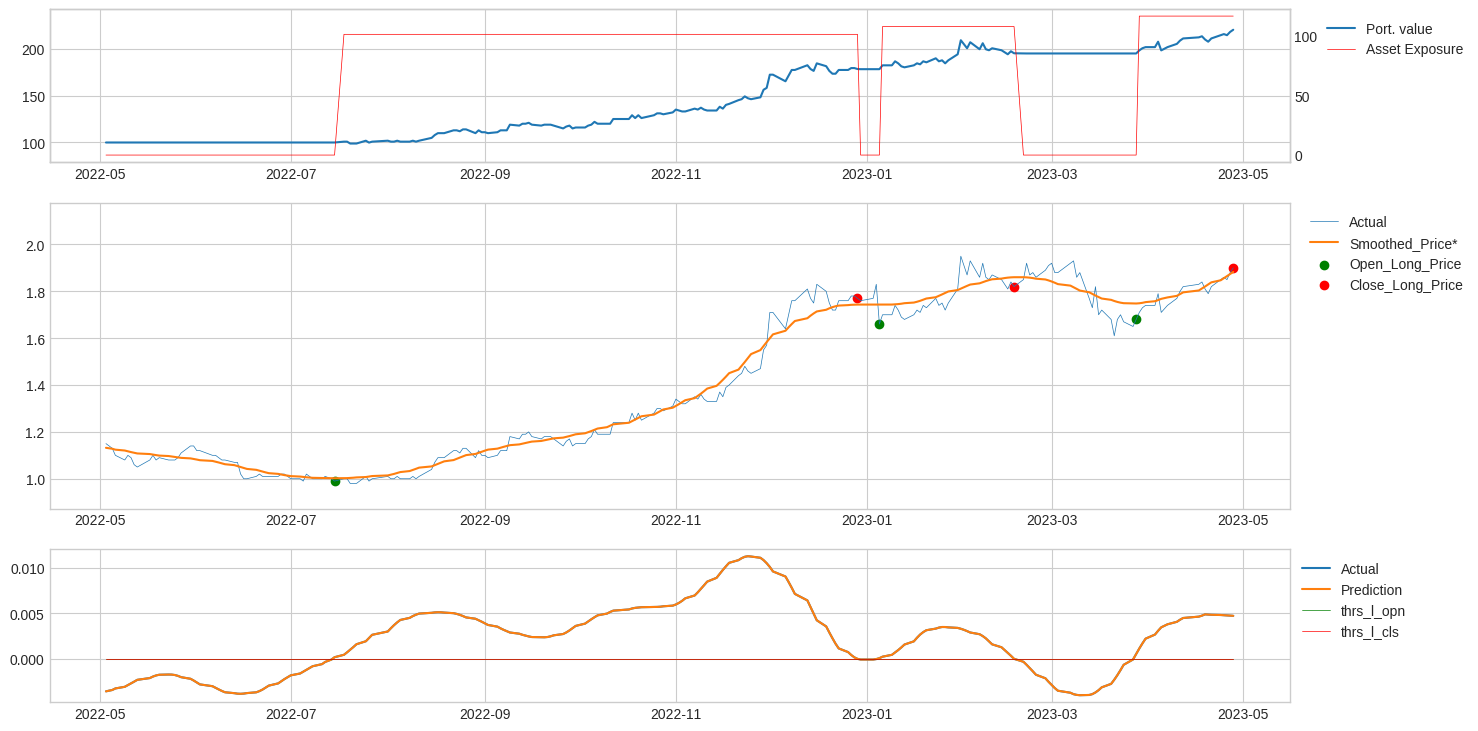

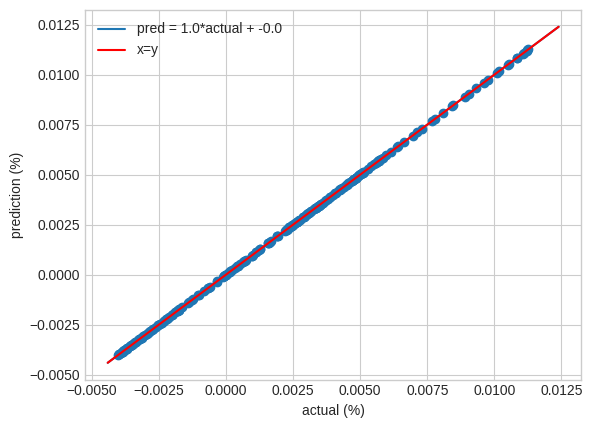

In [ ]:
df_label = smoothed_return_y_pred(df, model, X_test, target_scalers['Smoothed_Return*'], test_date)
df_label['Smoothed_Return_Pred'] = df_label['Smoothed_Return*'].copy(deep=True)
df_label = smoothed_return_strategy(df_label, thrs_l = [0, 0], thrs_s = [np.nan, np.nan])
backtest_label = Backtest(df_label, df_label.index[0], df_label.index[-1], col_name = None, initial_capital = 100, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
smoothed_return_report_summary_plot(df_label, backtest_label)

### -- Train

In [ ]:
df_thrs_l_train, df_thrs_s_train, thrs_report_train, backtest_result_train, df_backtest_result_train = smoothed_return_model_results(df, model, X_train, train_date, target_scalers['Smoothed_Return*'])

Start : 			2020-05-05 00:00:00
End : 				2021-10-29 00:00:00
Duration : 			542 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		100 $
ROI : 				0.0 %
Ann. ROI : 			0.0 %
Ann. Volatility : 		0.0 %
Ann. Sharpe Ratio : 		nan
Port Max. Drawdown : 		0.0 %
Trade Max. Drawdown : 		0 %
Trade P10 Max. Drawdown : 	0 %
Win Rate : 			0 %
No. of trades : 		0 times
Avg. Holding Duration : 	0.0 hrs.
Max. Holding Duration : 	0.0 hrs.
Rewards to Risk : 		0 times
Expectency : 			0 %
Buy&Hold ROI : 			80.0 %
Buy&Hold Ann. ROI : 		48.56 %
Buy&Hold Ann. Volatility : 	49.06 %
Buy&Hold Ann. Sharpe Ratio : 	0.99



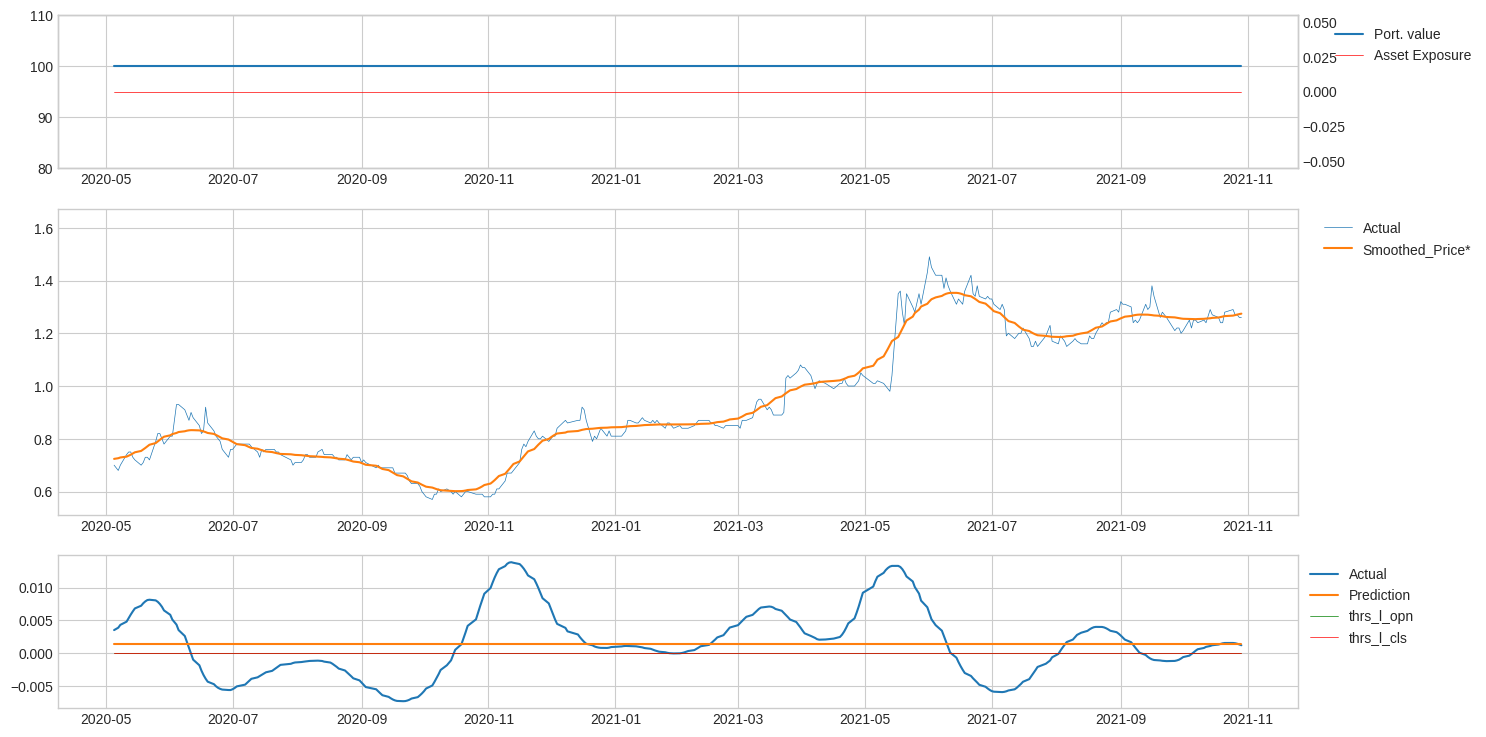

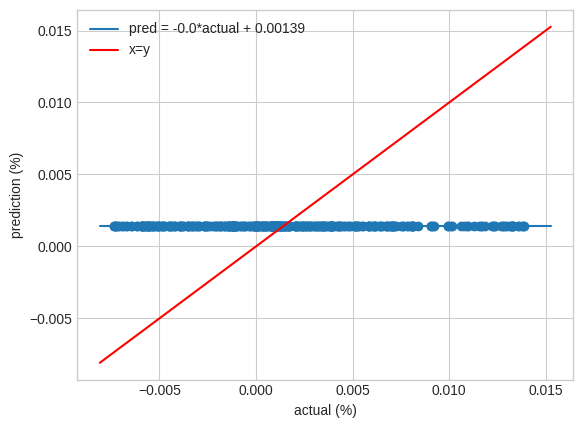

In [ ]:
k = 'backtest_0_l'
smoothed_return_report_summary_plot(backtest_result_train[k]['df'], backtest_result_train[k]['backtest'])

### -- Val

In [ ]:
df_thrs_l_val, df_thrs_s_val, thrs_report_val, backtest_result_val, df_backtest_result_val = smoothed_return_model_results(df, model, X_val, val_date, target_scalers['Smoothed_Return*'])

Start : 			2021-11-01 00:00:00
End : 				2022-04-29 00:00:00
Duration : 			179 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		100 $
ROI : 				0.0 %
Ann. ROI : 			0.0 %
Ann. Volatility : 		0.0 %
Ann. Sharpe Ratio : 		nan
Port Max. Drawdown : 		0.0 %
Trade Max. Drawdown : 		0 %
Trade P10 Max. Drawdown : 	0 %
Win Rate : 			0 %
No. of trades : 		0 times
Avg. Holding Duration : 	0.0 hrs.
Max. Holding Duration : 	0.0 hrs.
Rewards to Risk : 		0 times
Expectency : 			0 %
Buy&Hold ROI : 			-7.14 %
Buy&Hold Ann. ROI : 		-14.03 %
Buy&Hold Ann. Volatility : 	22.92 %
Buy&Hold Ann. Sharpe Ratio : 	-0.61



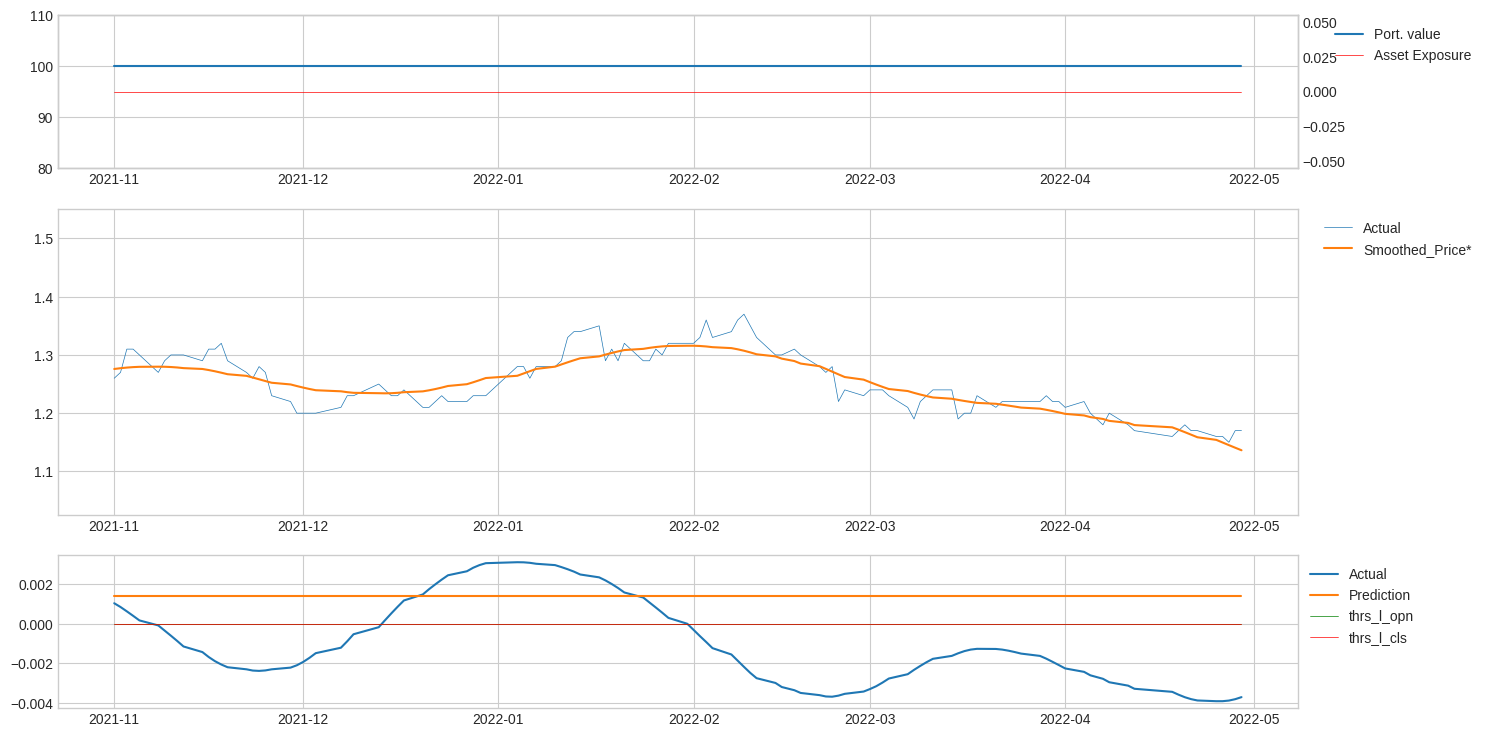

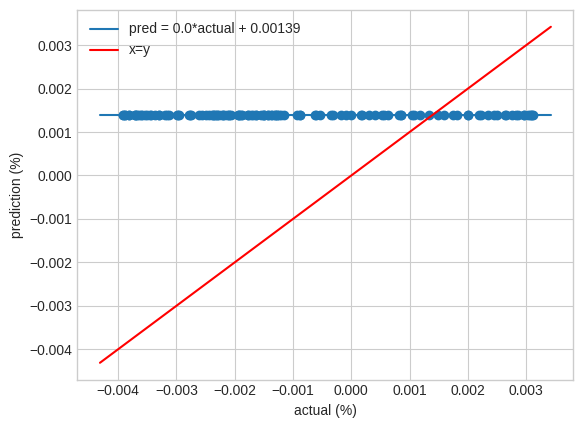

In [ ]:
k = 'backtest_0_l'
smoothed_return_report_summary_plot(backtest_result_val[k]['df'], backtest_result_val[k]['backtest'])

In [ ]:
thrs_cus = {}
thrs_cus['backtest_cus_l'] = thrs_report_val['backtest_opt_l']
thrs_cus['backtest_cus_s'] = thrs_report_val['backtest_opt_s']

## - SR Test (Model from validation)

In [ ]:
df_thrs_l_test, df_thrs_s_test, thrs_report_test, backtest_result_test, df_backtest_result_test = smoothed_return_model_results(df, model, X_test, test_date, target_scalers['Smoothed_Return*'], thrs_cus)

Start : 			2022-05-03 00:00:00
End : 				2023-04-28 00:00:00
Duration : 			360 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		100 $
ROI : 				0.0 %
Ann. ROI : 			0.0 %
Ann. Volatility : 		0.0 %
Ann. Sharpe Ratio : 		nan
Port Max. Drawdown : 		0.0 %
Trade Max. Drawdown : 		0 %
Trade P10 Max. Drawdown : 	0 %
Win Rate : 			0 %
No. of trades : 		0 times
Avg. Holding Duration : 	0.0 hrs.
Max. Holding Duration : 	0.0 hrs.
Rewards to Risk : 		0 times
Expectency : 			0 %
Buy&Hold ROI : 			65.22 %
Buy&Hold Ann. ROI : 		66.37 %
Buy&Hold Ann. Volatility : 	33.72 %
Buy&Hold Ann. Sharpe Ratio : 	1.97



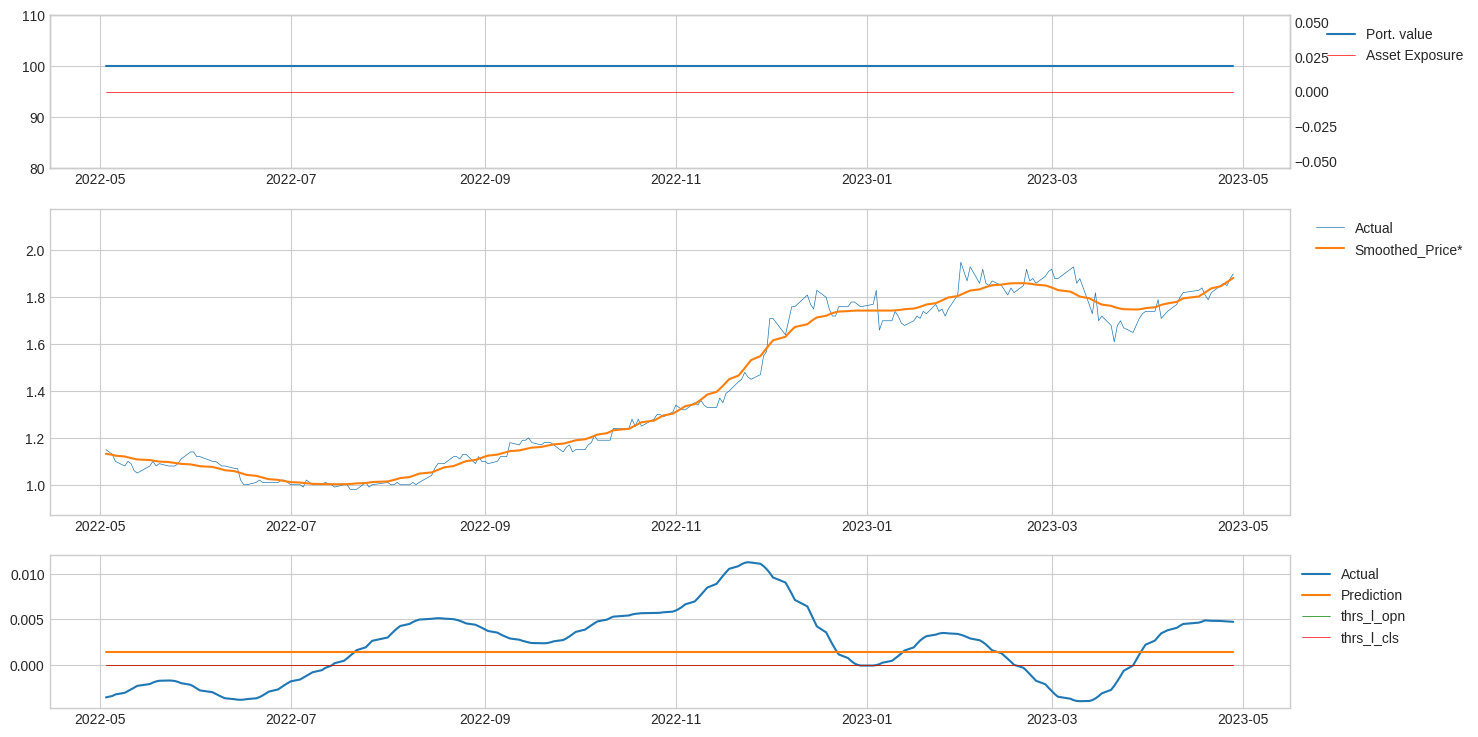

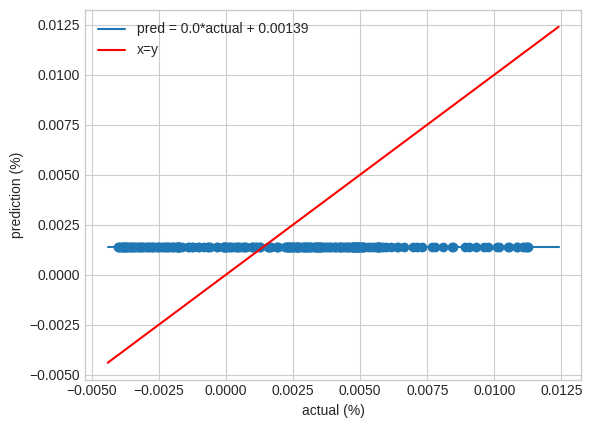

In [ ]:
k = 'backtest_0_l'
smoothed_return_report_summary_plot(backtest_result_test[k]['df'], backtest_result_test[k]['backtest'])
# print(backtest_result_test[k]['df'])
# print(backtest_result_test[k]['backtest'])

## - RSI

### -- RSI function

In [ ]:
def RSI_model_results(df, date_index, initial_capital = 100):
  df_evaluation = df[OHLC_features + targets2].copy(deep=True)
  df_evaluation['RSI'] = ta.momentum.RSIIndicator(close=df_evaluation['Close'], window=n_ind, fillna=False).rsi()
  df_evaluation = df_evaluation[test_date[0]:test_date[-1]]

  # thrs_range = np.linspace(10, 90, 9)
  # thrs_range_l_opn = thrs_range
  # thrs_range_l_cls = thrs_range
  # thrs_range_s_opn = thrs_range
  # thrs_range_s_cls = thrs_range
  thrs_range_l_opn = [30]
  thrs_range_l_cls = [70]
  thrs_range_s_opn = [70]
  thrs_range_s_cls = [30]

  # Long
  df_thrs_l = []
  for thrs_l_opn in thrs_range_l_opn:
    for thrs_l_cls in thrs_range_l_cls:
      df_evaluation_thrs = RSI_strategy(df_evaluation, thrs_l = [thrs_l_opn, thrs_l_cls], thrs_s = [np.nan, np.nan])
      backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
      df_thrs_l.append([thrs_l_opn, thrs_l_cls, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_l = pd.DataFrame(data = df_thrs_l, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])

  df_thrs_l = df_thrs_l.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Short
  df_thrs_s = []
  for thrs_s_opn in thrs_range_s_opn:
    for thrs_s_cls in thrs_range_s_cls:
      df_evaluation_thrs = RSI_strategy(df_evaluation, thrs_l = [np.nan, np.nan], thrs_s = [thrs_s_opn, thrs_s_cls])
      backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
      df_thrs_s.append([np.nan, np.nan, thrs_s_opn, thrs_s_cls] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_s = pd.DataFrame(data = df_thrs_s, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])


  df_thrs_s = df_thrs_s.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # # Backtest report
  thrs_report = {'backtest_opt_l': {'thrs_l':[df_thrs_l['thrs_l_opn'][0], df_thrs_l['thrs_l_cls'][0]], 'thrs_s':[np.nan, np.nan]},
                 'backtest_opt_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[df_thrs_s['thrs_s_opn'][0], df_thrs_s['thrs_s_cls'][0]]},
                 'backtest_0_l': {'thrs_l':[30, 70], 'thrs_s':[np.nan, np.nan]}, # normal trigger point for RSI strategy = 30/70
                 'backtest_0_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[70, 30]} # normal trigger point for RSI strategy = 30/70
                }

  backtest_result = {}
  df_backtest_result = []

  for k, v in thrs_report.items():
    df_evaluation_thrs = RSI_strategy(df_evaluation, thrs_l = [v['thrs_l'][0], v['thrs_l'][1]], thrs_s = [v['thrs_s'][0], v['thrs_s'][1]])
    backtest_evaluation = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
    backtest_result[k] = {'df': df_evaluation_thrs.copy(deep=True),
                          'backtest': backtest_evaluation.copy()}
    df_backtest_result.append([k] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_backtest_result = pd.DataFrame(data = df_backtest_result, columns=['name',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])
  return df_thrs_l, df_thrs_s, backtest_result, df_backtest_result

In [ ]:
# create strategy
def RSI_strategy(df,  thrs_l = [0, 0], # [Open (>=) , Close (<=)]
                             thrs_s = [0, 0], signal = 'RSI'):   # [Open (<=) , Close (>=)]
  df['thrs_l_opn'] = thrs_l[0]
  df['thrs_l_cls'] = thrs_l[1]
  df['thrs_s_opn'] = thrs_s[0]
  df['thrs_s_cls'] = thrs_s[1]

  df['Long_Position'] = np.nan
  df['Long_Price'] = np.nan
  df['Short_Position'] = np.nan
  df['Short_Price'] = np.nan

  for i in range(len(df)):
    idx = df.index[i]
    # long position =======
    if i == 0:
      df.loc[idx, 'Long_Position'] = 0
      pass

    elif df[signal][i-1] < df['thrs_l_opn'][i] and df[signal][i] >= df['thrs_l_opn'][i]: # smooth return pass thrs upward
      # trigger open long position
      df.loc[idx, 'Long_Position'] = 1
      df.loc[idx, 'Long_Price'] = df['Close'][i]

    elif (df[signal][i-1] > df['thrs_l_cls'][i] and df[signal][i] <= df['thrs_l_cls'][i]) or i == len(df) - 1: # smooth return pass thrs downward
      # trigger close long position
      df.loc[idx, 'Long_Position'] = 0
      df.loc[idx, 'Long_Price'] = df['Close'][i]

    else:
      # do nothing (continue last position)
      df.loc[idx, 'Long_Position'] = df['Long_Position'][i-1]


    # short position =======
    if i == 0:
      df.loc[idx, 'Short_Position'] = 0

    elif df[signal][i-1] > df['thrs_s_opn'][i] and df[signal][i] <= df['thrs_s_opn'][i]: # smooth return pass thrs downward
      # trigger open short position
      df.loc[idx, 'Short_Position'] = 1
      df.loc[idx, 'Short_Price'] = df['Close'][i]

    elif (df[signal][i-1] < df['thrs_s_cls'][i] and df[signal][i] >= df['thrs_s_cls'][i]) or i == len(df) - 1: # smooth return pass thrs upward
      # trigger close short position
      df.loc[idx, 'Short_Position'] = 0
      df.loc[idx, 'Short_Price'] = df['Close'][i]

    else:
      # do nothing (continue last position)
      df.loc[idx, 'Short_Position'] = df['Short_Position'][i-1]

  return df

In [ ]:
def RSI_report_plot(df, backtest):
  # Plot Graph

  fig,a =  plt.subplots(3, 1, figsize=(16,9), gridspec_kw={'height_ratios': [1, 2, 1]})

  # Section 1) port curve ==========================
  lns1 = a[0].plot(backtest['_curve']['port_value'], label='Port. value')
  a[0].set_ylim(backtest['_curve']['port_value'].min()*0.8,backtest['_curve']['port_value'].max()*1.1)
  a02 = a[0].twinx()
  lns2 = a02.plot(backtest['_curve']['port_size'], label='Asset Exposure', color='r', linewidth=0.5)
  # a02.set_ylim(min(0, backtest['_curve']['port_size'].min()),backtest['_curve']['port_size'].max())
  a02.grid(False)
  lns = lns1 + lns2
  labs = [l.get_label() for l in lns]
  a[0].legend(lns, labs, bbox_to_anchor=(1.15, 1))

  # Section 2) asset price curve =======================
  df['Open_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) < df['Long_Position'], df['Long_Price'], np.nan)
  df['Close_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) > df['Long_Position'], df['Long_Price'], np.nan)
  df['Open_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) < df['Short_Position'], df['Short_Price'], np.nan)
  df['Close_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) > df['Short_Position'], df['Short_Price'], np.nan)
  if df['Long_Position'][0] > 0: df['Open_Long_Price'][0] = df['Long_Price'][0]
  if df['Short_Position'][0] > 0: df['Open_Short_Price'][0] = df['Shprt_Price'][0]

  a[1].plot(df['Close'], label='Actual', linewidth=0.5)
  a[1].plot(df['Smoothed_Price*'], label='Smoothed_Price*')

  if not df['Open_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Long_Price'], c='green', label='Open_Long_Price')
  if not df['Close_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Long_Price'], c='red', label='Close_Long_Price')
  if not df['Open_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Short_Price'], c='red', label='Open_Short_Price', marker='x')
  if not df['Close_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Short_Price'], c='green', label='Close_Short_Price', marker='x')

  a[1].legend(bbox_to_anchor=(1.15, 1))
  a[1].set_ylim(df['Low'].min()*0.9,df['High'].max()*1.1)

  # Section 3) indicator curve =============================
  a[2].plot(df['RSI'], label='RSI')
  if not df['thrs_l_opn'].isnull().all():
    a[2].plot(df['thrs_l_opn'], label='thrs_l_opn', linewidth=0.5, c='green')
  if not df['thrs_l_cls'].isnull().all():
    a[2].plot(df['thrs_l_cls'], label='thrs_l_cls', linewidth=0.5, c='red')
  if not df['thrs_s_opn'].isnull().all():
    a[2].plot(df['thrs_s_opn'], label='thrs_s_opn', linewidth=0.5, c='red', linestyle=(0, (10,3)))
  if not df['thrs_s_cls'].isnull().all():
    a[2].plot(df['thrs_s_cls'], label='thrs_s_cls', linewidth=0.5, c='green', linestyle=(0, (10,3)))
  a[2].legend(bbox_to_anchor=(1, 1))

  plt.show()
  print()

In [ ]:
def RSI_report_summary_plot(df, backtest):
  report_summary(backtest, print_report = True, return_list = False)
  RSI_report_plot(df, backtest)

### -- RSI code

In [ ]:
df_thrs_l_rsi, df_thrs_s_rsi, backtest_result_rsi, df_backtest_result_rsi = RSI_model_results(df, test_date, initial_capital = 100)

Start : 			2022-05-03 00:00:00
End : 				2023-04-28 00:00:00
Duration : 			360 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		111.74 $
ROI : 				11.74 %
Ann. ROI : 			11.92 %
Ann. Volatility : 		15.36 %
Ann. Sharpe Ratio : 		0.78
Port Max. Drawdown : 		-14.05 %
Trade Max. Drawdown : 		-11.01 %
Trade P10 Max. Drawdown : 	-10.1 %
Win Rate : 			50.0 %
No. of trades : 		2 times
Avg. Holding Duration : 	1776.0 hrs.
Max. Holding Duration : 	2664.0 hrs.
Rewards to Risk : 		11.5 times
Expectency : 			5.89 %
Buy&Hold ROI : 			65.22 %
Buy&Hold Ann. ROI : 		66.37 %
Buy&Hold Ann. Volatility : 	33.72 %
Buy&Hold Ann. Sharpe Ratio : 	1.97



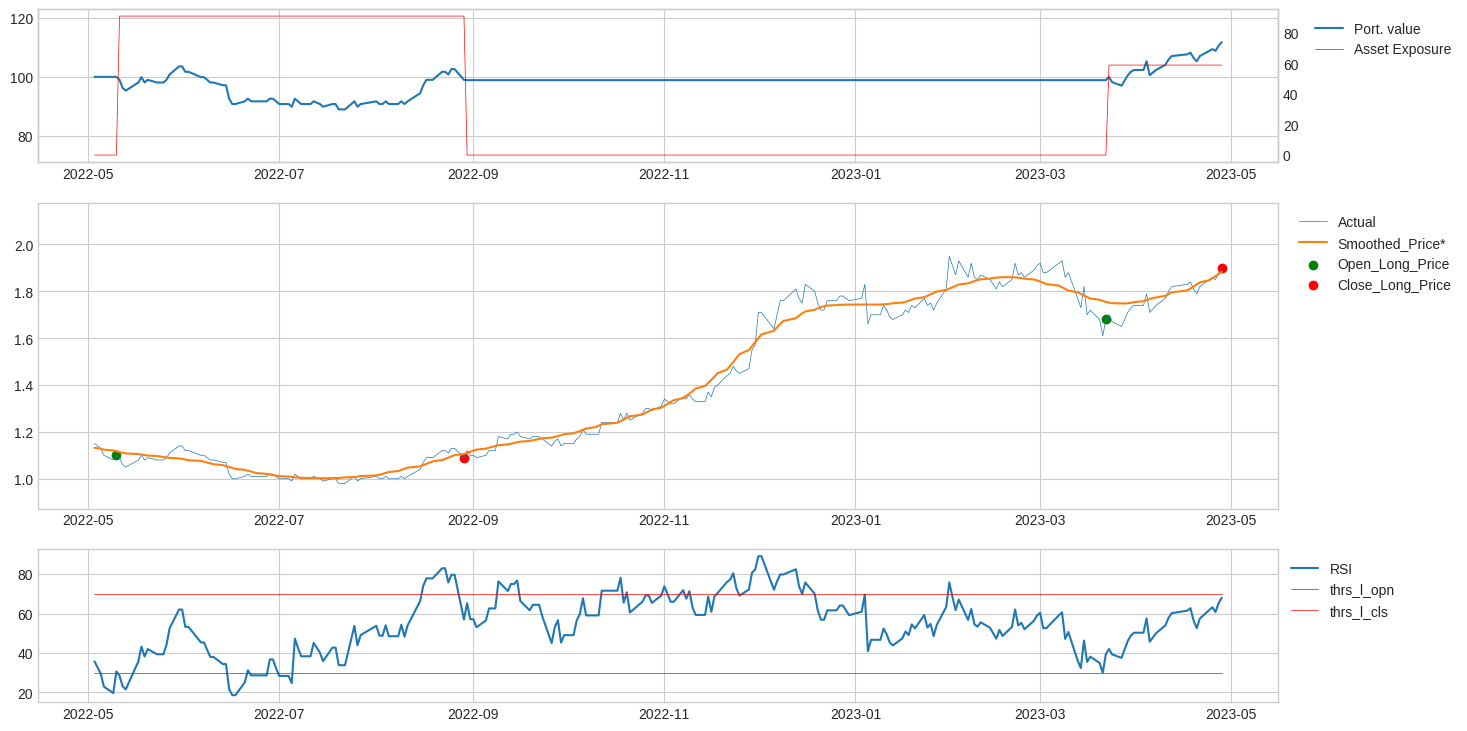

In [ ]:
k = 'backtest_0_l'
RSI_report_summary_plot(backtest_result_rsi[k]['df'], backtest_result_rsi[k]['backtest'])

## - MACD

### -- MACD function

In [ ]:
def MACD_model_results(df, date_index, initial_capital = 100):
  df_evaluation = df[OHLC_features + targets2].copy(deep=True)
  df_evaluation['MACD'] = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=False).macd()
  df_evaluation['MACD_signal'] = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=False).macd_signal()
  df_evaluation = df_evaluation[test_date[0]:test_date[-1]]

  # Long
  df_thrs_l = []
  df_evaluation_thrs = MACD_strategy(df_evaluation, position = ['long'])
  backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
  df_thrs_l.append([np.nan, np.nan, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_l = pd.DataFrame(data = df_thrs_l, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])

  df_thrs_l = df_thrs_l.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Short
  df_thrs_s = []
  df_evaluation_thrs = MACD_strategy(df_evaluation, position = ['short'])
  backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
  df_thrs_s.append([np.nan, np.nan, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_s = pd.DataFrame(data = df_thrs_s, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])


  df_thrs_s = df_thrs_s.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Backtest report
  thrs_report = {'backtest_opt_l': {'thrs_l':[df_thrs_l['thrs_l_opn'][0], df_thrs_l['thrs_l_cls'][0]], 'thrs_s':[np.nan, np.nan]},
                 'backtest_opt_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[df_thrs_s['thrs_s_opn'][0], df_thrs_s['thrs_s_cls'][0]]},
                 'backtest_0_l': {'thrs_l':[np.nan, np.nan], 'thrs_s':[np.nan, np.nan]},
                 'backtest_0_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[np.nan, np.nan]}
                }

  backtest_result = {}
  df_backtest_result = []

  for k, v in thrs_report.items():
    if k in ['backtest_opt_l', 'backtest_0_l']:
      position = ['long']
    elif k in ['backtest_opt_s', 'backtest_0_s']:
      position = ['short']

    df_evaluation_thrs = MACD_strategy(df_evaluation, position = position)
    backtest_evaluation = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
    backtest_result[k] = {'df': df_evaluation_thrs.copy(deep=True),
                          'backtest': backtest_evaluation.copy()}
    df_backtest_result.append([k] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_backtest_result = pd.DataFrame(data = df_backtest_result, columns=['name',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])
  return df_thrs_l, df_thrs_s, backtest_result, df_backtest_result

In [ ]:
# create strategy
def MACD_strategy(df, position = ['long'], signal = 'MACD', signal2 = 'MACD_signal'): # position = ['long'], ['short'], ['long', 'short']

  df['Long_Position'] = np.nan
  df['Long_Price'] = np.nan
  df['Short_Position'] = np.nan
  df['Short_Price'] = np.nan

  for i in range(len(df)):
    idx = df.index[i]
    # long position =======
    if 'long' in position:
      if i == 0:
        df.loc[idx, 'Long_Position'] = 0
        pass

      elif df[signal][i-1] < df[signal2][i-1] and df[signal][i] >= df[signal2][i]: # MACD cross MACD_signal upward
        # trigger open long position
        df.loc[idx, 'Long_Position'] = 1
        df.loc[idx, 'Long_Price'] = df['Close'][i]

      elif (df[signal][i-1] > df[signal2][i-1] and df[signal][i] <= df[signal2][i]) or i == len(df) - 1: # MACD cross MACD_signal downward
        # trigger close long position
        df.loc[idx, 'Long_Position'] = 0
        df.loc[idx, 'Long_Price'] = df['Close'][i]

      else:
        # do nothing (continue last position)
        df.loc[idx, 'Long_Position'] = df['Long_Position'][i-1]


    # short position =======
    if 'short' in position:
      if i == 0:
        df.loc[idx, 'Short_Position'] = 0

      elif df[signal][i-1] > df[signal2][i-1] and df[signal][i] <= df[signal2][i]: # MACD cross MACD_signal downward
        # trigger open short position
        df.loc[idx, 'Short_Position'] = 1
        df.loc[idx, 'Short_Price'] = df['Close'][i]

      elif (df[signal][i-1] < df[signal2][i-1] and df[signal][i] >= df[signal2][i]) or i == len(df) - 1: # MACD cross MACD_signal upward
        # trigger close short position
        df.loc[idx, 'Short_Position'] = 0
        df.loc[idx, 'Short_Price'] = df['Close'][i]

      else:
        # do nothing (continue last position)
        df.loc[idx, 'Short_Position'] = df['Short_Position'][i-1]

  return df

In [ ]:
def MACD_report_plot(df, backtest):
  # Plot Graph

  fig,a =  plt.subplots(3, 1, figsize=(16,9), gridspec_kw={'height_ratios': [1, 2, 1]})

  # Section 1) port curve ==========================
  lns1 = a[0].plot(backtest['_curve']['port_value'], label='Port. value')
  a[0].set_ylim(backtest['_curve']['port_value'].min()*0.8,backtest['_curve']['port_value'].max()*1.1)
  a02 = a[0].twinx()
  lns2 = a02.plot(backtest['_curve']['port_size'], label='Asset Exposure', color='r', linewidth=0.5)
  # a02.set_ylim(min(0, backtest['_curve']['port_size'].min()),backtest['_curve']['port_size'].max())
  a02.grid(False)
  lns = lns1 + lns2
  labs = [l.get_label() for l in lns]
  a[0].legend(lns, labs, bbox_to_anchor=(1.15, 1))

  # Section 2) asset price curve =======================
  df['Open_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) < df['Long_Position'], df['Long_Price'], np.nan)
  df['Close_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) > df['Long_Position'], df['Long_Price'], np.nan)
  df['Open_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) < df['Short_Position'], df['Short_Price'], np.nan)
  df['Close_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) > df['Short_Position'], df['Short_Price'], np.nan)
  if df['Long_Position'][0] > 0: df['Open_Long_Price'][0] = df['Long_Price'][0]
  if df['Short_Position'][0] > 0: df['Open_Short_Price'][0] = df['Shprt_Price'][0]

  a[1].plot(df['Close'], label='Actual', linewidth=0.5)
  a[1].plot(df['Smoothed_Price*'], label='Smoothed_Price*')

  if not df['Open_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Long_Price'], c='green', label='Open_Long_Price')
  if not df['Close_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Long_Price'], c='red', label='Close_Long_Price')
  if not df['Open_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Short_Price'], c='red', label='Open_Short_Price', marker='x')
  if not df['Close_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Short_Price'], c='green', label='Close_Short_Price', marker='x')

  a[1].legend(bbox_to_anchor=(1.15, 1))
  a[1].set_ylim(df['Low'].min()*0.9,df['High'].max()*1.1)

  # Section 3) indicator curve =============================
  a[2].plot(df['MACD'], label='MACD')
  a[2].plot(df['MACD_signal'], label='MACD_signal')
  a[2].legend(bbox_to_anchor=(1, 1))

  plt.show()
  print()

In [ ]:
def MACD_report_summary_plot(df, backtest):
  report_summary(backtest, print_report = True, return_list = False)
  MACD_report_plot(df, backtest)

### -- MACD code

In [ ]:
df_thrs_l_macd, df_thrs_s_macd, backtest_result_macd, df_backtest_result_macd = MACD_model_results(df, test_date, initial_capital = 100)

In [ ]:
backtest_result_macd[k]['backtest']['_curve']

,port_value,port_size,dd,dd_dur
timestamp,,,,
2022-05-03,100.000000,0.00000,0.000000,0 days
2022-05-05,100.000000,0.00000,0.000000,0 days
2022-05-06,100.000000,0.00000,0.000000,0 days
2022-05-09,100.000000,0.00000,0.000000,0 days
2022-05-10,100.000000,0.00000,0.000000,0 days
...,...,...,...,...
2023-04-24,140.701400,76.12641,-0.053889,83 days
2023-04-25,141.462663,76.12641,-0.048770,84 days
2023-04-26,140.701400,76.12641,-0.053889,85 days


Start : 			2022-05-03 00:00:00
End : 				2023-04-28 00:00:00
Duration : 			360 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		144.51 $
ROI : 				44.51 %
Ann. ROI : 			45.25 %
Ann. Volatility : 		24.39 %
Ann. Sharpe Ratio : 		1.86
Port Max. Drawdown : 		-12.56 %
Trade Max. Drawdown : 		-4.02 %
Trade P10 Max. Drawdown : 	-3.79 %
Win Rate : 			55.56 %
No. of trades : 		9 times
Avg. Holding Duration : 	549.3 hrs.
Max. Holding Duration : 	1560.0 hrs.
Rewards to Risk : 		5.52 times
Expectency : 			4.43 %
Buy&Hold ROI : 			65.22 %
Buy&Hold Ann. ROI : 		66.37 %
Buy&Hold Ann. Volatility : 	33.72 %
Buy&Hold Ann. Sharpe Ratio : 	1.97



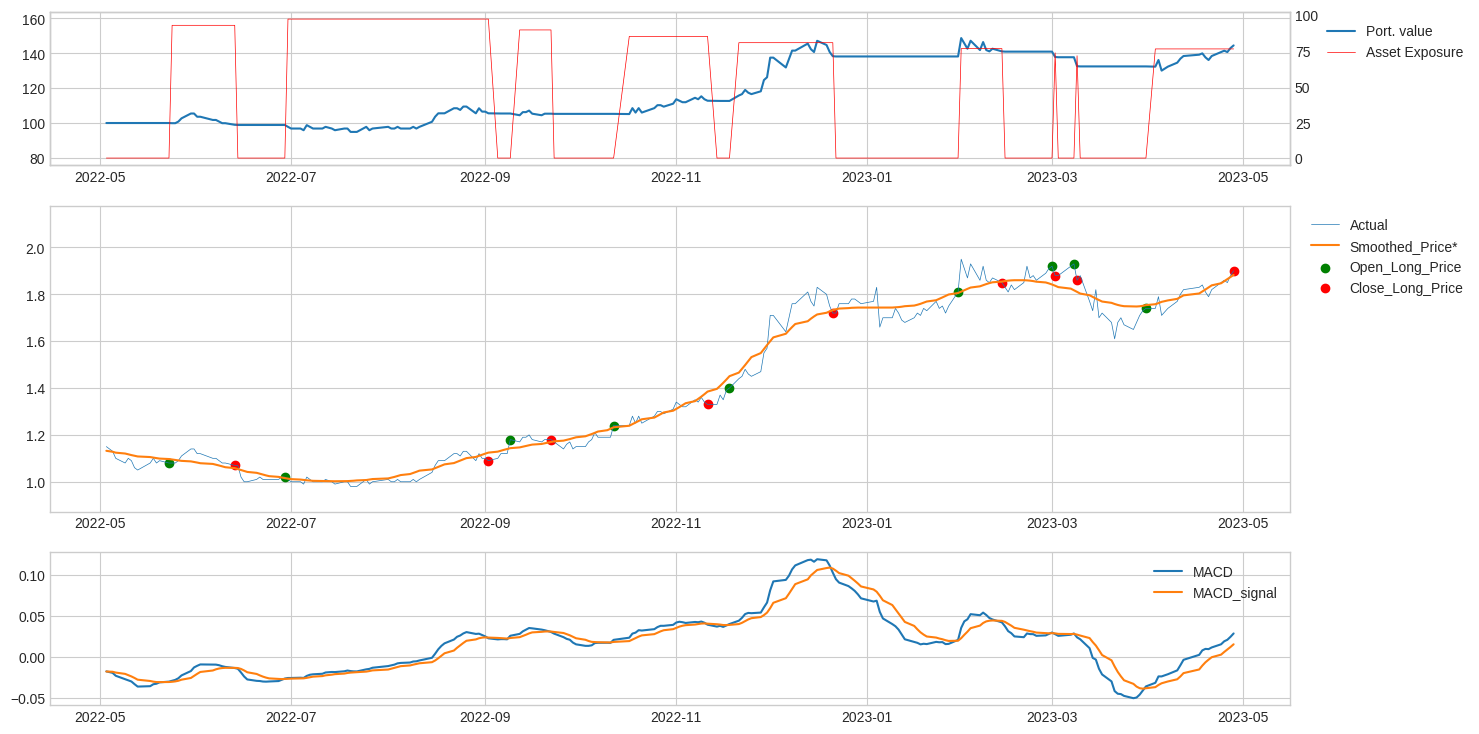

In [ ]:
k = 'backtest_0_l'
MACD_report_summary_plot(backtest_result_macd[k]['df'], backtest_result_macd[k]['backtest'])

## - SMA

### -- SMA function

In [ ]:
def SMA_model_results(df, date_index, initial_capital = 100):
  df_evaluation = df[OHLC_features + targets2].copy(deep=True)
  df_evaluation['SMA_15'] = ta.trend.SMAIndicator(close=df['Close'], window=15, fillna=False).sma_indicator()
  df_evaluation['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50, fillna=False).sma_indicator()
  df_evaluation = df_evaluation[test_date[0]:test_date[-1]]

  # Long
  df_thrs_l = []
  df_evaluation_thrs = SMA_strategy(df_evaluation, position = ['long'])
  backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
  df_thrs_l.append([np.nan, np.nan, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_l = pd.DataFrame(data = df_thrs_l, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])

  df_thrs_l = df_thrs_l.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Short
  df_thrs_s = []
  df_evaluation_thrs = SMA_strategy(df_evaluation, position = ['short'])
  backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
  df_thrs_s.append([np.nan, np.nan, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_s = pd.DataFrame(data = df_thrs_s, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])


  df_thrs_s = df_thrs_s.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Backtest report
  thrs_report = {'backtest_opt_l': {'thrs_l':[df_thrs_l['thrs_l_opn'][0], df_thrs_l['thrs_l_cls'][0]], 'thrs_s':[np.nan, np.nan]},
                 'backtest_opt_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[df_thrs_s['thrs_s_opn'][0], df_thrs_s['thrs_s_cls'][0]]},
                 'backtest_0_l': {'thrs_l':[np.nan, np.nan], 'thrs_s':[np.nan, np.nan]},
                 'backtest_0_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[np.nan, np.nan]}
                }

  backtest_result = {}
  df_backtest_result = []

  for k, v in thrs_report.items():
    if k in ['backtest_opt_l', 'backtest_0_l']:
      position = ['long']
    elif k in ['backtest_opt_s', 'backtest_0_s']:
      position = ['short']

    df_evaluation_thrs = SMA_strategy(df_evaluation, position = position)
    backtest_evaluation = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
    backtest_result[k] = {'df': df_evaluation_thrs.copy(deep=True),
                          'backtest': backtest_evaluation.copy()}
    df_backtest_result.append([k] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_backtest_result = pd.DataFrame(data = df_backtest_result, columns=['name',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])
  return df_thrs_l, df_thrs_s, backtest_result, df_backtest_result

In [ ]:
# create strategy
def SMA_strategy(df, position = ['long'], signal = 'SMA_15', signal2 = 'SMA_50'): # position = ['long'], ['short'], ['long', 'short']

  df['Long_Position'] = np.nan
  df['Long_Price'] = np.nan
  df['Short_Position'] = np.nan
  df['Short_Price'] = np.nan

  for i in range(len(df)):
    idx = df.index[i]
    # long position =======
    if 'long' in position:
      if i == 0:
        df.loc[idx, 'Long_Position'] = 0
        pass

      elif df[signal][i-1] < df[signal2][i-1] and df[signal][i] >= df[signal2][i]: # SMA50 cross SMA200 upward
        # trigger open long position
        df.loc[idx, 'Long_Position'] = 1
        df.loc[idx, 'Long_Price'] = df['Close'][i]

      elif (df[signal][i-1] > df[signal2][i-1] and df[signal][i] <= df[signal2][i]) or i == len(df) - 1: # SMA50 cross SMA200 downward
        # trigger close long position
        df.loc[idx, 'Long_Position'] = 0
        df.loc[idx, 'Long_Price'] = df['Close'][i]

      else:
        # do nothing (continue last position)
        df.loc[idx, 'Long_Position'] = df['Long_Position'][i-1]


    # short position =======
    if 'short' in position:
      if i == 0:
        df.loc[idx, 'Short_Position'] = 0

      elif df[signal][i-1] > df[signal2][i-1] and df[signal][i] <= df[signal2][i]: # SMA50 cross SMA200 downward
        # trigger open short position
        df.loc[idx, 'Short_Position'] = 1
        df.loc[idx, 'Short_Price'] = df['Close'][i]

      elif (df[signal][i-1] < df[signal2][i-1] and df[signal][i] >= df[signal2][i]) or i == len(df) - 1: # SMA50 cross SMA200 upward
        # trigger close short position
        df.loc[idx, 'Short_Position'] = 0
        df.loc[idx, 'Short_Price'] = df['Close'][i]

      else:
        # do nothing (continue last position)
        df.loc[idx, 'Short_Position'] = df['Short_Position'][i-1]

  return df

In [ ]:
def SMA_report_plot(df, backtest):
  # Plot Graph

  fig,a =  plt.subplots(3, 1, figsize=(16,9), gridspec_kw={'height_ratios': [1, 2, 1]})

  # Section 1) port curve ==========================
  lns1 = a[0].plot(backtest['_curve']['port_value'], label='Port. value')
  a[0].set_ylim(backtest['_curve']['port_value'].min()*0.8,backtest['_curve']['port_value'].max()*1.1)
  a02 = a[0].twinx()
  lns2 = a02.plot(backtest['_curve']['port_size'], label='Asset Exposure', color='r', linewidth=0.5)
  # a02.set_ylim(min(0, backtest['_curve']['port_size'].min()),backtest['_curve']['port_size'].max())
  a02.grid(False)
  lns = lns1 + lns2
  labs = [l.get_label() for l in lns]
  a[0].legend(lns, labs, bbox_to_anchor=(1.15, 1))

  # Section 2) asset price curve =======================
  df['Open_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) < df['Long_Position'], df['Long_Price'], np.nan)
  df['Close_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) > df['Long_Position'], df['Long_Price'], np.nan)
  df['Open_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) < df['Short_Position'], df['Short_Price'], np.nan)
  df['Close_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) > df['Short_Position'], df['Short_Price'], np.nan)
  if df['Long_Position'][0] > 0: df['Open_Long_Price'][0] = df['Long_Price'][0]
  if df['Short_Position'][0] > 0: df['Open_Short_Price'][0] = df['Shprt_Price'][0]

  a[1].plot(df['Close'], label='Actual', linewidth=0.5)
  a[1].plot(df['Smoothed_Price*'], label='Smoothed_Price*')

  if not df['Open_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Long_Price'], c='green', label='Open_Long_Price')
  if not df['Close_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Long_Price'], c='red', label='Close_Long_Price')
  if not df['Open_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Short_Price'], c='red', label='Open_Short_Price', marker='x')
  if not df['Close_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Short_Price'], c='green', label='Close_Short_Price', marker='x')

  a[1].legend(bbox_to_anchor=(1.15, 1))
  a[1].set_ylim(df['Low'].min()*0.9,df['High'].max()*1.1)

  # Section 3) indicator curve =============================
  a[2].plot(df['SMA_15'], label='SMA_15')
  a[2].plot(df['SMA_50'], label='SMA_50')
  a[2].legend(bbox_to_anchor=(1, 1))

  plt.show()
  print()

In [ ]:
def SMA_report_summary_plot(df, backtest):
  report_summary(backtest, print_report = True, return_list = False)
  SMA_report_plot(df, backtest)

### -- SMA code

In [ ]:
df_thrs_l_sma, df_thrs_s_sma, backtest_result_sma, df_backtest_result_sma = SMA_model_results(df, test_date, initial_capital = 100)

Start : 			2022-05-03 00:00:00
End : 				2023-04-28 00:00:00
Duration : 			360 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		155.36 $
ROI : 				55.36 %
Ann. ROI : 			56.31 %
Ann. Volatility : 		30.24 %
Ann. Sharpe Ratio : 		1.86
Port Max. Drawdown : 		-17.45 %
Trade Max. Drawdown : 		-0.1 %
Trade P10 Max. Drawdown : 	-0.09 %
Win Rate : 			100.0 %
No. of trades : 		2 times
Avg. Holding Duration : 	2604.0 hrs.
Max. Holding Duration : 	5184.0 hrs.
Rewards to Risk : 		inf times
Expectency : 			27.37 %
Buy&Hold ROI : 			65.22 %
Buy&Hold Ann. ROI : 		66.37 %
Buy&Hold Ann. Volatility : 	33.72 %
Buy&Hold Ann. Sharpe Ratio : 	1.97



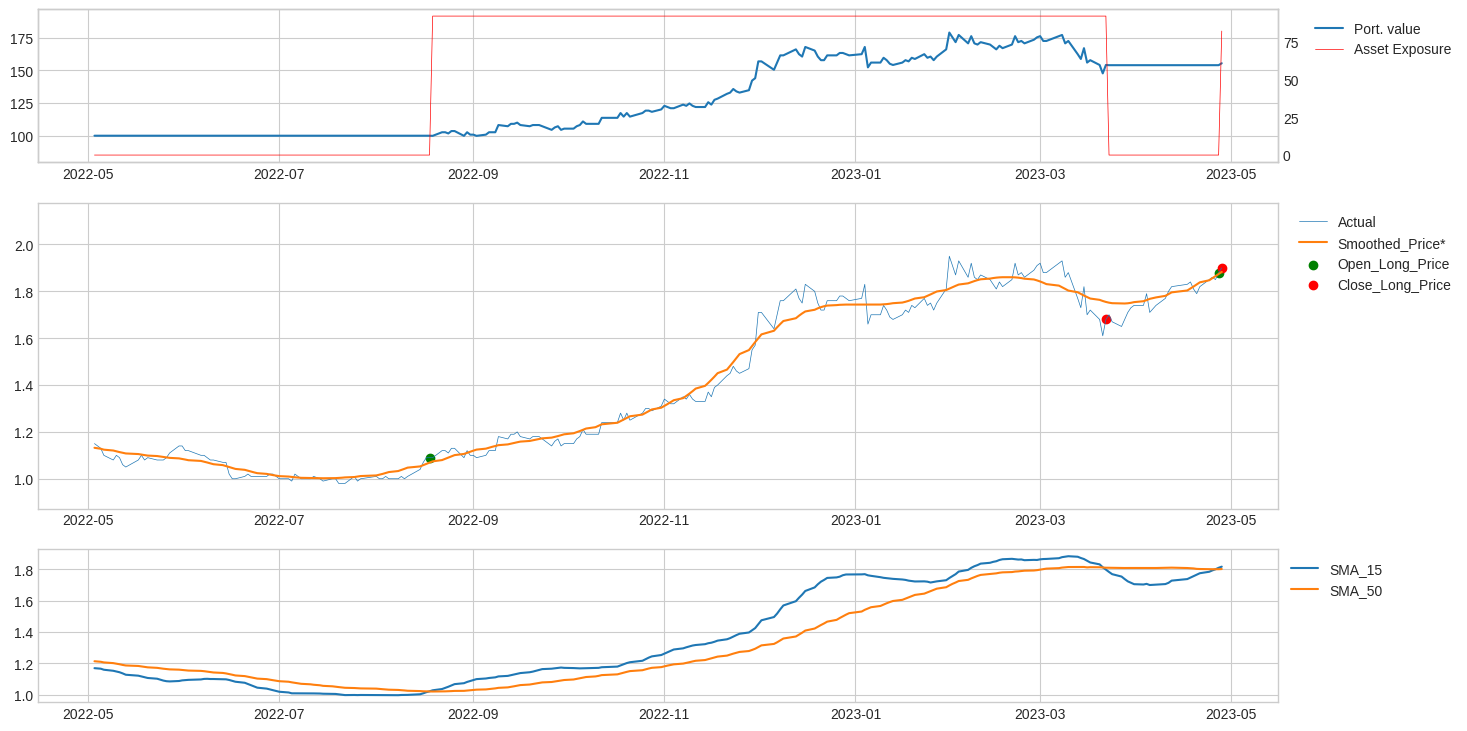

In [ ]:
k = 'backtest_0_l'
SMA_report_summary_plot(backtest_result_sma[k]['df'], backtest_result_sma[k]['backtest'])

## - Stochastics

### -- Stochastics function

In [ ]:
def STO_model_results(df, date_index, initial_capital = 100):
  df_evaluation = df[OHLC_features + targets2].copy(deep=True)
  df_evaluation['%K'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=n_ind, smooth1=n_ind, smooth2=n_ind, fillna=False).stochrsi_k()*100
  df_evaluation['%D'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=n_ind, smooth1=n_ind, smooth2=n_ind, fillna=False).stochrsi_d()*100
  df_evaluation = df_evaluation[test_date[0]:test_date[-1]]

  # thrs_range = np.linspace(10, 90, 9)
  # thrs_range_l_opn = thrs_range
  # thrs_range_l_cls = thrs_range
  # thrs_range_s_opn = thrs_range
  # thrs_range_s_cls = thrs_range
  thrs_range_l_opn = [20]
  thrs_range_l_cls = [80]
  thrs_range_s_opn = [80]
  thrs_range_s_cls = [20]

  # Long
  df_thrs_l = []
  for thrs_l_opn in thrs_range_l_opn:
    for thrs_l_cls in thrs_range_l_cls:
      df_evaluation_thrs = STO_strategy(df_evaluation, thrs_l = [thrs_l_opn, thrs_l_cls], thrs_s = [np.nan, np.nan])
      backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
      df_thrs_l.append([thrs_l_opn, thrs_l_cls, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_l = pd.DataFrame(data = df_thrs_l, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])

  df_thrs_l = df_thrs_l.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Short
  df_thrs_s = []
  for thrs_s_opn in thrs_range_s_opn:
    for thrs_s_cls in thrs_range_s_cls:
      df_evaluation_thrs = STO_strategy(df_evaluation, thrs_l = [np.nan, np.nan], thrs_s = [thrs_s_opn, thrs_s_cls])
      backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
      df_thrs_s.append([np.nan, np.nan, thrs_s_opn, thrs_s_cls] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_s = pd.DataFrame(data = df_thrs_s, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])


  df_thrs_s = df_thrs_s.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # # Backtest report
  thrs_report = {'backtest_opt_l': {'thrs_l':[df_thrs_l['thrs_l_opn'][0], df_thrs_l['thrs_l_cls'][0]], 'thrs_s':[np.nan, np.nan]},
                 'backtest_opt_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[df_thrs_s['thrs_s_opn'][0], df_thrs_s['thrs_s_cls'][0]]},
                 'backtest_0_l': {'thrs_l':[20, 80], 'thrs_s':[np.nan, np.nan]}, # normal trigger point for STO strategy = 20/80
                 'backtest_0_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[80, 20]} # normal trigger point for STO strategy = 20/80
                }

  backtest_result = {}
  df_backtest_result = []

  for k, v in thrs_report.items():
    df_evaluation_thrs = STO_strategy(df_evaluation, thrs_l = [v['thrs_l'][0], v['thrs_l'][1]], thrs_s = [v['thrs_s'][0], v['thrs_s'][1]])
    backtest_evaluation = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
    backtest_result[k] = {'df': df_evaluation_thrs.copy(deep=True),
                          'backtest': backtest_evaluation.copy()}
    df_backtest_result.append([k] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_backtest_result = pd.DataFrame(data = df_backtest_result, columns=['name',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])
  return df_thrs_l, df_thrs_s, backtest_result, df_backtest_result

In [ ]:
# create strategy
def STO_strategy(df,  thrs_l = [0, 0], # [Open (>=) , Close (<=)]
                             thrs_s = [0, 0], signal = '%K', signal2 = '%D'):   # [Open (<=) , Close (>=)]
  df['thrs_l_opn'] = thrs_l[0]
  df['thrs_l_cls'] = thrs_l[1]
  df['thrs_s_opn'] = thrs_s[0]
  df['thrs_s_cls'] = thrs_s[1]

  df['Long_Position'] = np.nan
  df['Long_Price'] = np.nan
  df['Short_Position'] = np.nan
  df['Short_Price'] = np.nan

  for i in range(len(df)):
    idx = df.index[i]
    # long position =======
    if i == 0:
      df.loc[idx, 'Long_Position'] = 0
      pass

    elif df[signal2][i] <= df['thrs_l_opn'][i] and df[signal][i-1] < df[signal2][i-1] and df[signal][i] >= df[signal2][i]: # %D <= thres , %K cross %D upward
      # trigger open long position
      df.loc[idx, 'Long_Position'] = 1
      df.loc[idx, 'Long_Price'] = df['Close'][i]

    elif (df[signal2][i] >= df['thrs_l_cls'][i] and df[signal][i-1] > df[signal2][i-1] and df[signal][i] <= df[signal2][i]) or i == len(df) - 1: # %D >= thres , %K cross %D downward
      # trigger close long position
      df.loc[idx, 'Long_Position'] = 0
      df.loc[idx, 'Long_Price'] = df['Close'][i]

    else:
      # do nothing (continue last position)
      df.loc[idx, 'Long_Position'] = df['Long_Position'][i-1]


    # short position =======
    if i == 0:
      df.loc[idx, 'Short_Position'] = 0

    elif df[signal2][i] >= df['thrs_s_cls'][i] and df[signal][i-1] > df[signal2][i-1] and df[signal][i] <= df[signal2][i]: # %D >= thres , %K cross %D downward
      # trigger open short position
      df.loc[idx, 'Short_Position'] = 1
      df.loc[idx, 'Short_Price'] = df['Close'][i]

    elif (df[signal2][i] <= df['thrs_s_opn'][i] and df[signal][i-1] < df[signal2][i-1] and df[signal][i] >= df[signal2][i]) or i == len(df) - 1: # %D <= thres , %K cross %D upward
      # trigger close short position
      df.loc[idx, 'Short_Position'] = 0
      df.loc[idx, 'Short_Price'] = df['Close'][i]

    else:
      # do nothing (continue last position)
      df.loc[idx, 'Short_Position'] = df['Short_Position'][i-1]

  return df

In [ ]:
def STO_report_plot(df, backtest):
  # Plot Graph

  fig,a =  plt.subplots(3, 1, figsize=(16,9), gridspec_kw={'height_ratios': [1, 2, 1]})

  # Section 1) port curve ==========================
  lns1 = a[0].plot(backtest['_curve']['port_value'], label='Port. value')
  a[0].set_ylim(backtest['_curve']['port_value'].min()*0.8,backtest['_curve']['port_value'].max()*1.1)
  a02 = a[0].twinx()
  lns2 = a02.plot(backtest['_curve']['port_size'], label='Asset Exposure', color='r', linewidth=0.5)
  # a02.set_ylim(min(0, backtest['_curve']['port_size'].min()),backtest['_curve']['port_size'].max())
  a02.grid(False)
  lns = lns1 + lns2
  labs = [l.get_label() for l in lns]
  a[0].legend(lns, labs, bbox_to_anchor=(1.15, 1))

  # Section 2) asset price curve =======================
  df['Open_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) < df['Long_Position'], df['Long_Price'], np.nan)
  df['Close_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) > df['Long_Position'], df['Long_Price'], np.nan)
  df['Open_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) < df['Short_Position'], df['Short_Price'], np.nan)
  df['Close_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) > df['Short_Position'], df['Short_Price'], np.nan)
  if df['Long_Position'][0] > 0: df['Open_Long_Price'][0] = df['Long_Price'][0]
  if df['Short_Position'][0] > 0: df['Open_Short_Price'][0] = df['Shprt_Price'][0]

  a[1].plot(df['Close'], label='Actual', linewidth=0.5)
  a[1].plot(df['Smoothed_Price*'], label='Smoothed_Price*')

  if not df['Open_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Long_Price'], c='green', label='Open_Long_Price')
  if not df['Close_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Long_Price'], c='red', label='Close_Long_Price')
  if not df['Open_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Short_Price'], c='red', label='Open_Short_Price', marker='x')
  if not df['Close_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Short_Price'], c='green', label='Close_Short_Price', marker='x')

  a[1].legend(bbox_to_anchor=(1.15, 1))
  a[1].set_ylim(df['Low'].min()*0.9,df['High'].max()*1.1)

  # Section 3) indicator curve =============================
  a[2].plot(df['%K'], label='%K')
  a[2].plot(df['%D'], label='%D')
  if not df['thrs_l_opn'].isnull().all():
    a[2].plot(df['thrs_l_opn'], label='thrs_l_opn', linewidth=0.5, c='green')
  if not df['thrs_l_cls'].isnull().all():
    a[2].plot(df['thrs_l_cls'], label='thrs_l_cls', linewidth=0.5, c='red')
  if not df['thrs_s_opn'].isnull().all():
    a[2].plot(df['thrs_s_opn'], label='thrs_s_opn', linewidth=0.5, c='red', linestyle=(0, (10,3)))
  if not df['thrs_s_cls'].isnull().all():
    a[2].plot(df['thrs_s_cls'], label='thrs_s_cls', linewidth=0.5, c='green', linestyle=(0, (10,3)))
  a[2].legend(bbox_to_anchor=(1, 1))

  plt.show()
  print()

In [ ]:
def STO_report_summary_plot(df, backtest):
  report_summary(backtest, print_report = True, return_list = False)
  STO_report_plot(df, backtest)

### -- Stochastics code

In [ ]:
df_thrs_l_sto, df_thrs_s_sto, backtest_result_sto, df_backtest_result_sto = STO_model_results(df, test_date, initial_capital = 100)

Start : 			2022-05-03 00:00:00
End : 				2023-04-28 00:00:00
Duration : 			360 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		108.71 $
ROI : 				8.71 %
Ann. ROI : 			8.84 %
Ann. Volatility : 		25.16 %
Ann. Sharpe Ratio : 		0.35
Port Max. Drawdown : 		-17.45 %
Trade Max. Drawdown : 		-9.14 %
Trade P10 Max. Drawdown : 	-8.53 %
Win Rate : 			100.0 %
No. of trades : 		2 times
Avg. Holding Duration : 	2076.0 hrs.
Max. Holding Duration : 	2568.0 hrs.
Rewards to Risk : 		inf times
Expectency : 			4.32 %
Buy&Hold ROI : 			65.22 %
Buy&Hold Ann. ROI : 		66.37 %
Buy&Hold Ann. Volatility : 	33.72 %
Buy&Hold Ann. Sharpe Ratio : 	1.97



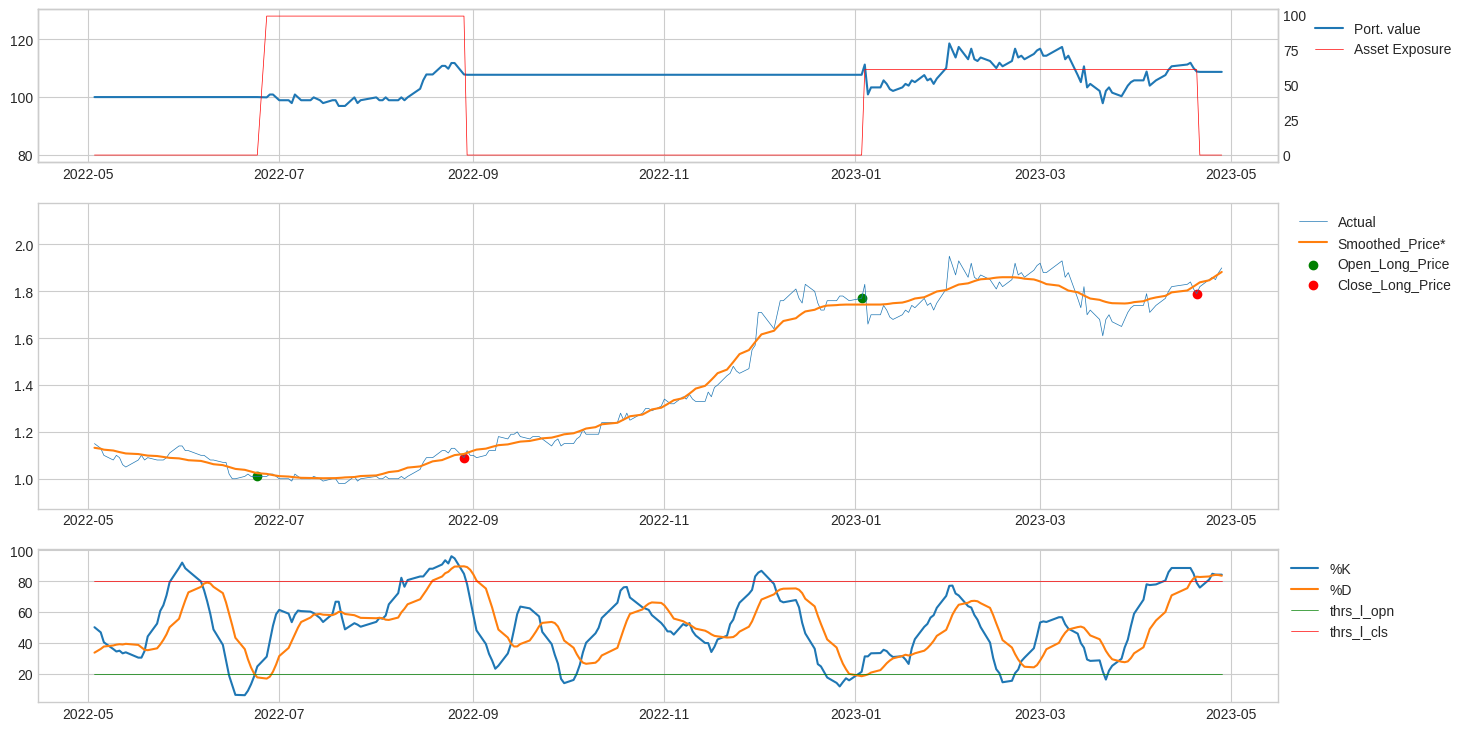

In [ ]:
k = 'backtest_0_l'
STO_report_summary_plot(backtest_result_sto[k]['df'], backtest_result_sto[k]['backtest'])

## - Buy & Hold

### -- B&H function

In [ ]:
def BH_model_results(df, date_index, initial_capital = 100):
  df_evaluation = df[OHLC_features + targets2].copy(deep=True)
  df_evaluation = df_evaluation[test_date[0]:test_date[-1]]

  # Long
  df_thrs_l = []
  df_evaluation_thrs = BH_strategy(df_evaluation, position = ['long'])
  backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
  df_thrs_l.append([np.nan, np.nan, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_l = pd.DataFrame(data = df_thrs_l, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])

  df_thrs_l = df_thrs_l.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Short
  df_thrs_s = []
  df_evaluation_thrs = BH_strategy(df_evaluation, position = ['short'])
  backtest_thrs = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
  df_thrs_s.append([np.nan, np.nan, np.nan, np.nan] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_thrs_s = pd.DataFrame(data = df_thrs_s, columns=['thrs_l_opn', 'thrs_l_cls', 'thrs_s_opn', 'thrs_s_cls',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])


  df_thrs_s = df_thrs_s.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

  # Backtest report
  thrs_report = {'backtest_opt_l': {'thrs_l':[df_thrs_l['thrs_l_opn'][0], df_thrs_l['thrs_l_cls'][0]], 'thrs_s':[np.nan, np.nan]},
                 'backtest_opt_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[df_thrs_s['thrs_s_opn'][0], df_thrs_s['thrs_s_cls'][0]]},
                 'backtest_0_l': {'thrs_l':[np.nan, np.nan], 'thrs_s':[np.nan, np.nan]},
                 'backtest_0_s': {'thrs_l':[np.nan, np.nan], 'thrs_s':[np.nan, np.nan]}
                }

  backtest_result = {}
  df_backtest_result = []

  for k, v in thrs_report.items():
    if k in ['backtest_opt_l', 'backtest_0_l']:
      position = ['long']
    elif k in ['backtest_opt_s', 'backtest_0_s']:
      position = ['short']

    df_evaluation_thrs = BH_strategy(df_evaluation, position = position)
    backtest_evaluation = Backtest(df_evaluation_thrs, df_evaluation_thrs.index[0], df_evaluation_thrs.index[-1], col_name = None, initial_capital = initial_capital, trd_fee_frac = trd_fee_frac, hld_fee_frac_hr = hld_fee_frac_hr)
    backtest_result[k] = {'df': df_evaluation_thrs.copy(deep=True),
                          'backtest': backtest_evaluation.copy()}
    df_backtest_result.append([k] + report_summary(backtest_thrs, print_report = False, return_list = True))

  df_backtest_result = pd.DataFrame(data = df_backtest_result, columns=['name',
                                                'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                                'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])
  return df_thrs_l, df_thrs_s, backtest_result, df_backtest_result

In [ ]:
# create strategy
def BH_strategy(df, position = ['long']): # position = ['long'], ['short'], ['long', 'short']

  df['Long_Position'] = np.nan
  df['Long_Price'] = np.nan
  df['Short_Position'] = np.nan
  df['Short_Price'] = np.nan

  for i in range(len(df)):
    idx = df.index[i]
    # long position =======
    if 'long' in position:
      if i == 0:
        # trigger open long position
        df.loc[idx, 'Long_Position'] = 1
        df.loc[idx, 'Long_Price'] = df['Close'][i]

      elif i == len(df) - 1:
        # trigger close long position
        df.loc[idx, 'Long_Position'] = 0
        df.loc[idx, 'Long_Price'] = df['Close'][i]

      else:
        # do nothing (continue last position)
        df.loc[idx, 'Long_Position'] = df['Long_Position'][i-1]


    # short position =======
    if 'short' in position:
      if i == 0:
        # trigger open short position
        df.loc[idx, 'Short_Position'] = 1
        df.loc[idx, 'Short_Price'] = df['Close'][i]

      elif i == len(df) - 1:
        # trigger close short position
        df.loc[idx, 'Short_Position'] = 0
        df.loc[idx, 'Short_Price'] = df['Close'][i]

      else:
        # do nothing (continue last position)
        df.loc[idx, 'Short_Position'] = df['Short_Position'][i-1]

  return df

In [ ]:
def BH_report_plot(df, backtest):
  # Plot Graph

  fig,a =  plt.subplots(2, 1, figsize=(16,9), gridspec_kw={'height_ratios': [1, 2]})

  # Section 1) port curve ==========================
  lns1 = a[0].plot(backtest['_curve']['port_value'], label='Port. value')
  a[0].set_ylim(backtest['_curve']['port_value'].min()*0.8,backtest['_curve']['port_value'].max()*1.1)
  a02 = a[0].twinx()
  lns2 = a02.plot(backtest['_curve']['port_size'], label='Asset Exposure', color='r', linewidth=0.5)
  # a02.set_ylim(min(0, backtest['_curve']['port_size'].min()),backtest['_curve']['port_size'].max())
  a02.grid(False)
  lns = lns1 + lns2
  labs = [l.get_label() for l in lns]
  a[0].legend(lns, labs, bbox_to_anchor=(1.15, 1))

  # Section 2) asset price curve =======================
  df['Open_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) < df['Long_Position'], df['Long_Price'], np.nan)
  df['Close_Long_Price'] = np.where(df['Long_Position'].shift(periods=1) > df['Long_Position'], df['Long_Price'], np.nan)
  df['Open_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) < df['Short_Position'], df['Short_Price'], np.nan)
  df['Close_Short_Price'] = np.where(df['Short_Position'].shift(periods=1) > df['Short_Position'], df['Short_Price'], np.nan)
  if df['Long_Position'][0] > 0: df['Open_Long_Price'][0] = df['Long_Price'][0]
  if df['Short_Position'][0] > 0: df['Open_Short_Price'][0] = df['Shprt_Price'][0]

  a[1].plot(df['Close'], label='Actual', linewidth=0.5)
  a[1].plot(df['Smoothed_Price*'], label='Smoothed_Price*')

  if not df['Open_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Long_Price'], c='green', label='Open_Long_Price')
  if not df['Close_Long_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Long_Price'], c='red', label='Close_Long_Price')
  if not df['Open_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Open_Short_Price'], c='red', label='Open_Short_Price', marker='x')
  if not df['Close_Short_Price'].isnull().all():
    a[1].scatter(df.index, df['Close_Short_Price'], c='green', label='Close_Short_Price', marker='x')

  a[1].legend(bbox_to_anchor=(1.15, 1))
  a[1].set_ylim(df['Low'].min()*0.9,df['High'].max()*1.1)

  # # Section 3) indicator curve =============================
  # a[2].plot(df['MACD'], label='MACD')
  # a[2].plot(df['MACD_signal'], label='MACD_signal')
  # a[2].legend(bbox_to_anchor=(1, 1))

  plt.show()
  print()

In [ ]:
def BH_report_summary_plot(df, backtest):
  report_summary(backtest, print_report = True, return_list = False)
  BH_report_plot(df, backtest)

### -- B&H code

In [ ]:
df_thrs_l_bh, df_thrs_s_bh, backtest_result_bh, df_backtest_result_bh = BH_model_results(df, test_date, initial_capital = 100)

Start : 			2022-05-03 00:00:00
End : 				2023-04-28 00:00:00
Duration : 			360 days 00:00:00
Initial Capital : 		100 $
Final Capital : 		165.12 $
ROI : 				65.12 %
Ann. ROI : 			66.27 %
Ann. Volatility : 		33.76 %
Ann. Sharpe Ratio : 		1.96
Port Max. Drawdown : 		-17.45 %
Trade Max. Drawdown : 		-14.88 %
Trade P10 Max. Drawdown : 	-14.88 %
Win Rate : 			100.0 %
No. of trades : 		1 times
Avg. Holding Duration : 	8640.0 hrs.
Max. Holding Duration : 	8640.0 hrs.
Rewards to Risk : 		inf times
Expectency : 			64.95 %
Buy&Hold ROI : 			65.22 %
Buy&Hold Ann. ROI : 		66.37 %
Buy&Hold Ann. Volatility : 	33.72 %
Buy&Hold Ann. Sharpe Ratio : 	1.97



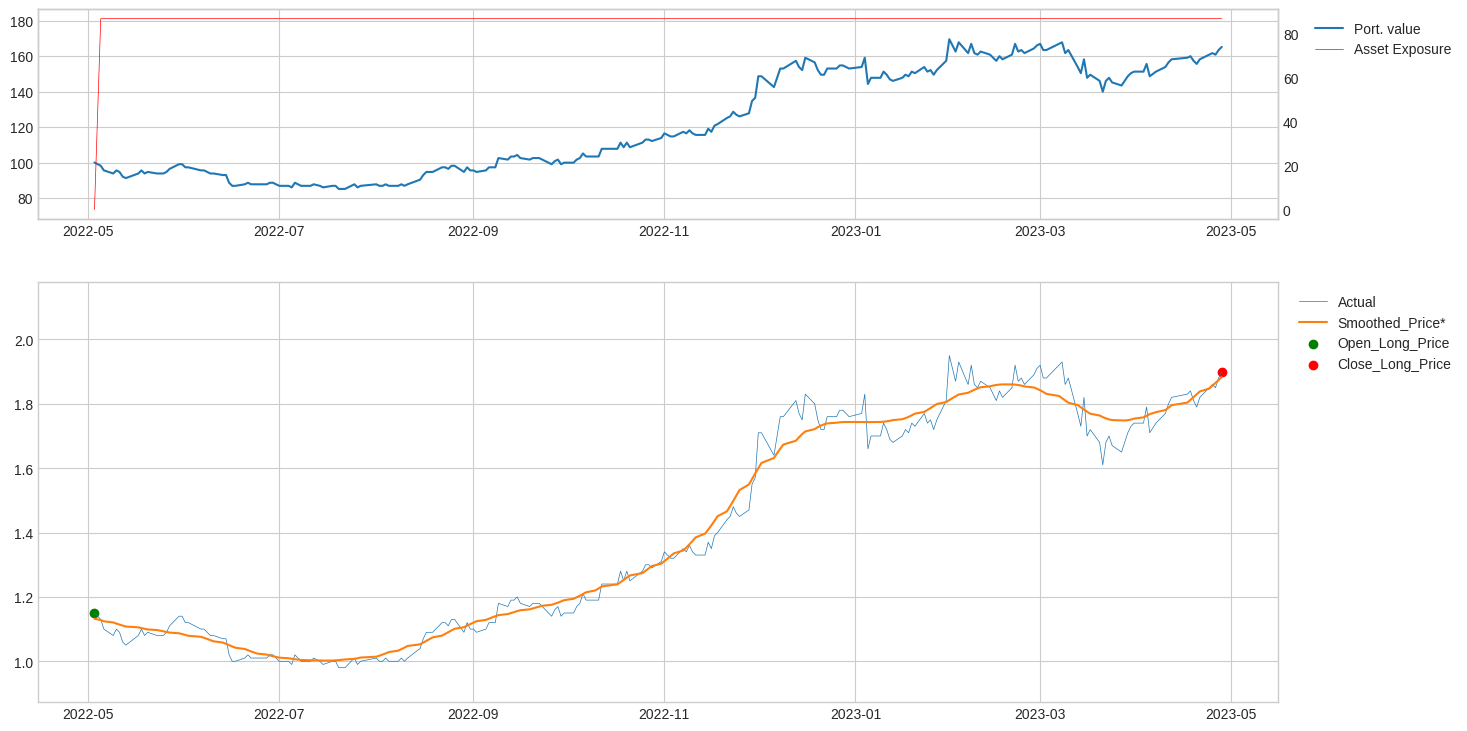

In [ ]:
k = 'backtest_0_l'
BH_report_summary_plot(backtest_result_bh[k]['df'], backtest_result_bh[k]['backtest'])

# Comparison

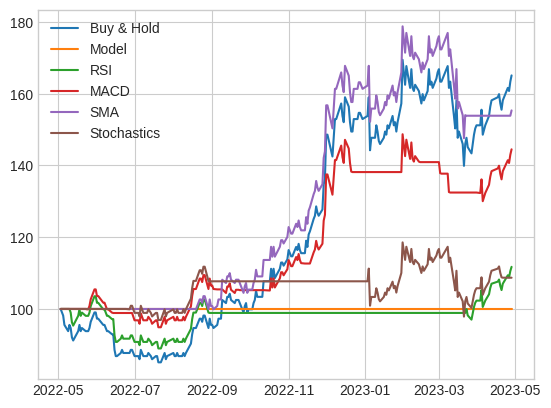

In [ ]:
plt.plot(backtest_result_bh[k]['backtest']['_curve']['port_value'], label='Buy & Hold')
plt.plot(backtest_result_test[k]['backtest']['_curve']['port_value'], label='Model')
plt.plot(backtest_result_rsi[k]['backtest']['_curve']['port_value'], label='RSI')
plt.plot(backtest_result_macd[k]['backtest']['_curve']['port_value'], label='MACD')
plt.plot(backtest_result_sma[k]['backtest']['_curve']['port_value'], label='SMA')
plt.plot(backtest_result_sto[k]['backtest']['_curve']['port_value'], label='Stochastics')
plt.legend()
plt.show()

In [ ]:
df_comparison = []
df_comparison.append(['Buy & Hold'] + report_summary(backtest_result_bh[k]['backtest'], print_report = False, return_list = True))
df_comparison.append(['Model'] + report_summary(backtest_result_test[k]['backtest'], print_report = False, return_list = True))
df_comparison.append(['RSI'] + report_summary(backtest_result_rsi[k]['backtest'], print_report = False, return_list = True))
df_comparison.append(['MACD'] + report_summary(backtest_result_macd[k]['backtest'], print_report = False, return_list = True))
df_comparison.append(['SMA'] + report_summary(backtest_result_sma[k]['backtest'], print_report = False, return_list = True))
df_comparison.append(['Stochastics'] + report_summary(backtest_result_sto[k]['backtest'], print_report = False, return_list = True))
df_comparison = pd.DataFrame(data = df_comparison, columns=['strategy',
                                              'start', 'end', 'dur', 'init_capital', 'final_capital', 'roi', 'roi_ann', 'volatility_ann', 'sharpe_ratio_ann',
                                              'port_mdd', 'trade_mdd', 'trade_P10_mdd', 'win_rate', 'no_trades', 'avg_hld_dur', 'max_hld_dur', 'reward_to_risk', 'expectency'])
df_comparison = df_comparison.sort_values(by=['roi'], ascending=False).reset_index(drop=True)

In [ ]:
df_comparison

,strategy,start,end,dur,init_capital,final_capital,roi,roi_ann,volatility_ann,sharpe_ratio_ann,port_mdd,trade_mdd,trade_P10_mdd,win_rate,no_trades,avg_hld_dur,max_hld_dur,reward_to_risk,expectency
0,Buy & Hold,2022-05-03,2023-04-28,360 days,100,165.12,65.12,66.27,33.76,1.96,-17.45,-14.88,-14.88,100.00,1,8640.0,8640.0,inf,64.95
1,SMA,2022-05-03,2023-04-28,360 days,100,155.36,55.36,56.31,30.24,1.86,-17.45,-0.10,-0.09,100.00,2,2604.0,5184.0,inf,27.37
2,MACD,2022-05-03,2023-04-28,360 days,100,144.51,44.51,45.25,24.39,1.86,-12.56,-4.02,-3.79,55.56,9,549.3,1560.0,5.52,4.43
3,RSI,2022-05-03,2023-04-28,360 days,100,111.74,11.74,11.92,15.36,0.78,-14.05,-11.01,-10.10,50.00,2,1776.0,2664.0,11.50,5.89
4,Stochastics,2022-05-03,2023-04-28,360 days,100,108.71,8.71,8.84,25.16,0.35,-17.45,-9.14,-8.53,100.00,2,2076.0,2568.0,inf,4.32
5,Model,2022-05-03,2023-04-28,360 days,100,100.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0,0.0,0.0,0.00,0.00


In [ ]:
# reporting purpose

print(f'train loss = {round(train_loss, 4)}')
print(f'validation loss = {round(val_loss, 4)}')
print(f'test loss = {round(test_loss, 4)}')

train loss = 0.0822
validation loss = 0.0582
test loss = 0.0658


In [ ]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 32, 33)]     0           []                               
                                                                                                  
 time2_vector_4 (Time2Vector)   (None, 32, 2)        128         ['input_29[0][0]']               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 32, 35)       0           ['input_29[0][0]',               
                                                                  'time2_vector_4[0][0]']         
                                                                                                  
 transformer_encoder_8 (Transfo  (None, 32, 35)      457682      ['concatenate_4[0][0]',   

In [ ]:
df_grid_results.sort_values(by=['val_loss'])

,cnn_no_node,lstm_no_node,train_loss,val_loss,test_loss,val_roi_ann,test_roi_ann
0,64,64,0.082182,0.058219,0.065838,0.0,0.0
1,64,128,0.083951,0.059870,0.067632,0.0,0.0
2,128,64,0.264102,NaN,0.244946,0.0,0.0
3,128,128,0.298754,NaN,0.288339,0.0,0.0


# 1 Prediction

In [ ]:
model = load_model(model_filename)

In [ ]:
# def last_prediction(symbols, kline_size, scaler, quantile_transformer, target_scalers, time_end = pd.Timestamp.now()):
def last_prediction(symbols, kline_size, quantile_transformer, scaler, target_scalers, model, time_end = pd.Timestamp.now(),
                    close_to_open = 'kline_size'): # close_to_open = kline_size or specify in minute
  time_end = pd.to_datetime(time_end)
  time_beg = time_end - 2*pd.Timedelta(binsizes[kline_size], unit='min')
  df = get_ohlcv('', [symbols], time_beg + timedelta(minutes=start_index_delta*binsizes[kline_size]*2), time_end, kline_size, save = False)[symbols]

  df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

  # assume close_to_open = kline_size
  if close_to_open == 'kline_size':
    close_to_open = pd.Timedelta(binsizes[kline_size], unit='min')
  else:
    close_to_open = pd.Timedelta(close_to_open, unit='min')

  # Check whether last candle is already closed or not
  # if not, delete last candle
  # (last candle open time + close_to_open) = close time
  now_to_close = time_end - (df.index[-1] + close_to_open)
  if now_to_close < pd.Timedelta(0):
    df = df[:-1]

  time_end = pd.to_datetime(df.loc[:time_end].index[-1])

  # slice time
  df = df[start_index_delta:]

  # extract feature
  df = df_extract_feature(df, rolling_indicator)
  df = df_cleaning(df, target_col=False)

  # feature engineering
  df, df_transform = df_transform_pct_change(df, pct_change_transform_features)

  # quantile transformer
  global quantile_transform_features
  quantile_transform_features = list(set(train_features.columns).intersection(quantile_transform_features))
  df_features = df_transform.copy(deep=True)

  df_features[quantile_transform_features] = pd.DataFrame(quantile_transformer.transform(df_features[quantile_transform_features].values),
                                      index=df_features[quantile_transform_features].index,
                                      columns=df_features[quantile_transform_features].columns)

  # Scaler
  scaled_df_features = pd.DataFrame(scaler.transform(df_features.values),
                                      index=df_features.index,
                                      columns=df_features.columns)

  # X4NN
  X = []
  for i in range(scaled_df_features.shape[0] - (T-1)):
      X.append(scaled_df_features.iloc[i:i+T].values)
  X = np.array(X)

  y_pred = model.predict(X, batch_size=BATCH, verbose=0)
  y_pred = target_scalers['Smoothed_Return*'].inverse_transform(y_pred.reshape(-1,1))

  return df, df_transform, df_features, scaled_df_features, X, y_pred

In [ ]:
investigate_time = '2023-05-02 17:00:00'
investigate_time = pd.to_datetime(investigate_time) + timedelta(1)

In [ ]:
print(df)

            Smoothed_Return*  Smoothed_Price*  Open  High   Low  Close  \
Date                                                                     
2020-03-18         -0.012690         0.671588  0.58  0.60  0.57   0.57   
2020-03-19         -0.011002         0.663065  0.57  0.58  0.56   0.57   
2020-03-20         -0.009172         0.655770  0.59  0.62  0.58   0.61   
2020-03-23         -0.007189         0.649756  0.57  0.58  0.56   0.56   
2020-03-24         -0.005071         0.645084  0.57  0.58  0.52   0.54   
...                      ...              ...   ...   ...   ...    ...   
2023-04-24          0.004807         1.847213  1.82  1.86  1.81   1.85   
2023-04-25          0.004784         1.856093  1.85  1.88  1.82   1.86   
2023-04-26          0.004761         1.864973  1.85  1.86  1.81   1.85   
2023-04-27          0.004739         1.873853  1.85  1.89  1.84   1.88   
2023-04-28          0.004717         1.882733  1.88  1.91  1.87   1.90   

               Volume  Rel_Open  Rel_

In [ ]:
t.tic()
df_last, df_transform_last, df_features_last, scaled_df_features_last, X_last, y_pred_last = last_prediction(symbols, kline_size, quantile_transformer, scaler, target_scalers, model, investigate_time)
t.toc()
print("{:.2%}".format(y_pred_last[0][0]))

Elapsed time is 3.602052 seconds.
0.14%


In [ ]:
print(scaled_df_features_last.equals(scaled_train_features[:investigate_time][-T:]))
print(df_features_last.equals(train_features[:investigate_time][-T:]))
print(df_transform_last.equals(df_transform[:investigate_time][-T:]))
print(df_last.equals(df[:investigate_time][-T:][df_last.columns]))

False
False
False
False


In [ ]:
focus_col = list(set(list(df_features_last.columns)).difference(set(['MACD', 'ADX', 'RSI', 'TSI', '%K', '%D', 'Rel_BB_hband', 'Rel_BB_lband', 'Rel_ATR', 'UI', 'ADI', 'OBV', 'CMF', 'FI'])))

In [ ]:
print(scaled_df_features_last[focus_col].equals(scaled_train_features[:investigate_time][-T:][focus_col]))
print(df_features_last[focus_col].equals(train_features[:investigate_time][-T:][focus_col]))
print(df_transform_last[focus_col].equals(df_transform[:investigate_time][-T:][focus_col]))
print(df_last[focus_col].equals(df[:investigate_time][-T:][df_last.columns][focus_col]))

False
False
False
False


## Verify correction of 1_prediction

In [ ]:
# investigate_time = '2005-01-03 00:00:00'
# investigate_time2 = pd.to_datetime(investigate_time) + timedelta(1)

In [ ]:
# t.tic()
# df_last, df_transform_last, df_features_last, scaled_df_features_last, X_last = last_prediction(symbols, kline_size, quantile_transformer, scaler, target_scalers, model, investigate_time2)
# t.toc()

In [ ]:
# print(scaled_df_features_last.equals(scaled_train_features[:investigate_time][-T:]))
# print(df_features_last.equals(train_features[:investigate_time][-T:]))
# print(df_transform_last.equals(df_transform[:investigate_time][-T:]))
# print(df_last.equals(df[:investigate_time][-T:][df_last.columns]))

In [ ]:
# focus_col = list(set(list(df_features_last.columns)).difference(set(['MACD', 'ADX', 'RSI', 'TSI', '%K', '%D', 'Rel_BB_hband', 'Rel_BB_lband', 'Rel_ATR', 'UI', 'ADI', 'OBV', 'CMF', 'FI'])))

In [ ]:
# print(scaled_df_features_last[focus_col].equals(scaled_train_features[:investigate_time][-T:][focus_col]))
# print(df_features_last[focus_col].equals(train_features[:investigate_time][-T:][focus_col]))
# print(df_transform_last[focus_col].equals(df_transform[:investigate_time][-T:][focus_col]))
# print(df_last[focus_col].equals(df[:investigate_time][-T:][df_last.columns][focus_col]))